In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import json
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import to_categorical

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_curve, auc
)

# Optuna pour l'optimisation bayésienne
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

# Configuration
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuration GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"GPU disponible: {physical_devices[0]}")
else:
    print("Exécution sur CPU")

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

GPU disponible: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow version: 2.19.0
Keras version: 3.10.0
NumPy version: 2.0.2
Pandas version: 2.3.3


# Classification Automatique de Pistaches par Deep Learning
## Optimisation de l'efficacité post-récolte

---

**Problématique** : Dans le but d'optimiser la valorisation des pistaches et d'améliorer l'efficacité des processus post-récolte, il est nécessaire de distinguer automatiquement différentes espèces ou qualités de pistaches à partir d'images. Étant donné un jeu de données composé de caractéristiques quantitatives extraites d'images de pistaches (telles que la forme, la couleur, la texture et d'autres attributs morphologiques), le problème consiste à construire un modèle prédictif capable d'assigner correctement chaque échantillon à sa catégorie connue.

**Objectif** : Minimiser les erreurs de classification afin de soutenir les décisions industrielles concernant le tri, l'emballage et la commercialisation des pistaches, en s'appuyant sur l'intelligence artificielle et l'analyse d'images.

**Dataset** : Pistachio_28_Features_Dataset (2148 échantillons, 28 caractéristiques, 2 classes)

---

**Date** : Février 2026

---

## 1. Environnement et Bibliothèques

L'environnement de travail repose sur **TensorFlow 2.19** avec **Keras 3.10**, exécuté sur GPU. L'utilisation du GPU accélère considérablement les phases d'entraînement et d'optimisation des hyperparamètres. Les bibliothèques complémentaires incluent **Scikit-learn** pour le prétraitement et les métriques, **Optuna** pour l'optimisation bayésienne, ainsi que **Matplotlib/Seaborn** pour la visualisation.

In [15]:
import os

print("Kaggle input folders:")
for root, dirs, files in os.walk("/kaggle/input"):
    if files:
        print(root)
        for f in files[:10]:
            print("  -", f)
        print()

Kaggle input folders:
/kaggle/input/datasets/irchnk/vrai-data-pistache
  - Pistachio_28_Features_Dataset.xls

/kaggle/input/datasets/irchnk/pistache-image
  - Pistachio_16_Features_Dataset.xlsx



In [16]:
# Configuration du style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration globale
CONFIG = {
    'data_path': '/kaggle/input/datasets/irchnk/vrai-data-pistache/Pistachio_28_Features_Dataset.xls',
    'random_seed': SEED,
    'test_size': 0.2,
    'validation_split': 0.2,
    'n_features': 28,
    'n_classes': 2,
    'batch_size': 8,
    'epochs': 50,
    'early_stopping_patience': 5,
    'optuna_trials': 50,
    'random_search_trials': 50
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  data_path: /kaggle/input/datasets/irchnk/vrai-data-pistache/Pistachio_28_Features_Dataset.xls
  random_seed: 42
  test_size: 0.2
  validation_split: 0.2
  n_features: 28
  n_classes: 2
  batch_size: 8
  epochs: 50
  early_stopping_patience: 5
  optuna_trials: 50
  random_search_trials: 50


---
## 2. Chargement et Exploration des Données

Le jeu de données est chargé à partir du fichier Excel `Pistachio_28_Features_Dataset.xls`. La configuration expérimentale prévoit une division 60/20/20 (entraînement/validation/test), un maximum de 50 époques avec arrêt précoce, et 50 essais pour chacune des méthodes d'optimisation des hyperparamètres.

In [17]:
# Chargement du dataset
print("Chargement du dataset Pistachio_28_Features...")
df = pd.read_excel(CONFIG['data_path'])

print(f"\nDimensions du dataset: {df.shape}")
print(f"Nombre d'échantillons: {len(df)}")
print(f"Nombre de caractéristiques: {len(df.columns) - 1}")

print("\nAperçu des premières lignes:")
display(df.head())

print("\nInformations sur le dataset:")
print(df.info())

print("\nValeurs manquantes:")
print(df.isnull().sum().sum())

Chargement du dataset Pistachio_28_Features...

Dimensions du dataset: (2148, 29)
Nombre d'échantillons: 2148
Nombre de caractéristiques: 28

Aperçu des premières lignes:


Area  Perimeter  Major_Axis  Minor_Axis  Eccentricity   Eqdiasq  Solidity  \
0  63391   1568.405    390.3396    236.7461        0.7951  284.0984    0.8665   
1  68358   1942.187    410.8594    234.7525        0.8207  295.0188    0.8765   
2  73589   1246.538    452.3630    220.5547        0.8731  306.0987    0.9172   
3  71106   1445.261    429.5291    216.0765        0.8643  300.8903    0.9589   
4  80087   1251.524    469.3783    220.9344        0.8823  319.3273    0.9657   

   Convex_Area  Extent  Aspect_Ratio  ...  StdDev_RR  StdDev_RG  StdDev_RB  \
0        73160  0.6394        1.6488  ...    17.7206    19.6024    21.1342   
1        77991  0.6772        1.7502  ...    26.7061    27.2112    25.1035   
2        80234  0.7127        2.0510  ...    19.0129    20.0703    20.7006   
3        74153  0.7028        1.9879  ...    18.1773    18.7152    29.7883   
4        82929  0.7459        2.1245  ...    23.4298    24.0878    23.1157   

   Skew_RR  Skew_RG  Skew_RB  Kurtosis_RR  Kurtosis_RG  Kurtosis_RB  \
0   0.4581   0.6635   0.7591       2.9692       3.0576       2.9542   
1  -0.3847  -0.2713  -0.2927       1.9807       2.1006       2.2152   
2  -0.6014  -0.4500   0.2998       3.5420       3.6856       4.1012   
3  -0.6943  -0.6278  -0.7798       2.8776       2.8748       2.8953   
4  -0.9287  -0.8134  -0.4970       2.9915       2.8813       2.7362   

               Class  
0  Kirmizi_Pistachio  
1  Kirmizi_Pistachio  
2  Kirmizi_Pistachio  
3  Kirmizi_Pistachio  
4  Kirmizi_Pistachio  

[5 rows x 29 columns]


Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Area           2148 non-null   int64  
 1   Perimeter      2148 non-null   float64
 2   Major_Axis     2148 non-null   float64
 3   Minor_Axis     2148 non-null   float64
 4   Eccentricity   2148 non-null   float64
 5   Eqdiasq        2148 non-null   float64
 6   Solidity       2148 non-null   float64
 7   Convex_Area    2148 non-null   int64  
 8   Extent         2148 non-null   float64
 9   Aspect_Ratio   2148 non-null   float64
 10  Roundness      2148 non-null   float64
 11  Compactness    2148 non-null   float64
 12  Shapefactor_1  2148 non-null   float64
 13  Shapefactor_2  2148 non-null   float64
 14  Shapefactor_3  2148 non-null   float64
 15  Shapefactor_4  2148 non-null   float64
 16  Mean_RR        2148 non-null   float64
 17  Mean_RG        2148 no


Distribution des classes:
Class
Kirmizi_Pistachio    1232
Siirt_Pistachio       916
Name: count, dtype: int64

Proportion:
Class
Kirmizi_Pistachio    0.573557
Siirt_Pistachio      0.426443
Name: count, dtype: float64


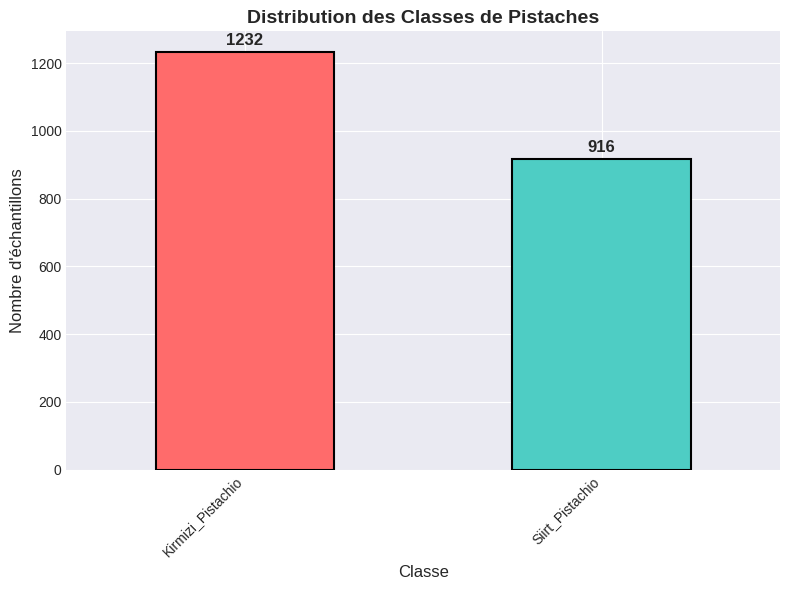

In [18]:
# Distribution des classes
print("\nDistribution des classes:")
class_counts = df['Class'].value_counts()
print(class_counts)
print(f"\nProportion:")
print(class_counts / len(df))

# Visualisation
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
class_counts.plot(kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4'], edgecolor='black', linewidth=1.5)
ax.set_title('Distribution des Classes de Pistaches', fontsize=14, fontweight='bold')
ax.set_xlabel('Classe', fontsize=12)
ax.set_ylabel('Nombre d\'échantillons', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for i, v in enumerate(class_counts):
    ax.text(i, v + 20, str(v), ha='center', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.savefig('distribution_classes_pistaches.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.1 Analyse de la Distribution des Classes

Le jeu de données totalise **2 148 échantillons** répartis en deux catégories :
- **Kirmizi Pistachio** : 1 232 échantillons, soit **57,4 %** du total
- **Siirt Pistachio** : 916 échantillons, soit **42,6 %** du total

Ce léger déséquilibre entre les classes (~15 points d'écart) est modéré. Il ne nécessite pas de technique de rééchantillonnage (SMOTE, sous-échantillonnage), mais justifie le recours à des métriques complémentaires à la simple exactitude globale, telles que la précision, le rappel et le F1-Score par classe.

In [19]:
# Statistiques descriptives
print("\nStatistiques descriptives des caractéristiques:")
display(df.describe())


Statistiques descriptives des caractéristiques:


Area    Perimeter   Major_Axis   Minor_Axis  Eccentricity  \
count    2148.000000  2148.000000  2148.000000  2148.000000   2148.000000   
mean    79950.655493  1425.971751   446.248968   238.311842      0.840219   
std     13121.737799   375.565503    32.445304    30.310695      0.048759   
min     29808.000000   858.363000   320.344500   133.509600      0.504900   
25%     71936.750000  1170.996250   426.508750   217.875825      0.817500   
50%     79905.500000  1262.785500   448.574750   236.416350      0.849650   
75%     89030.500000  1607.906250   468.509400   257.760150      0.875200   
max    124008.000000  2755.049100   541.966100   383.046100      0.946000   

           Eqdiasq     Solidity    Convex_Area       Extent  Aspect_Ratio  \
count  2148.000000  2148.000000    2148.000000  2148.000000   2148.000000   
mean    317.919173     0.940093   85015.839851     0.716067      1.898154   
std      26.908600     0.050452   13154.919327     0.052532      0.240100   
min     194.814600     0.588000   37935.000000     0.427200      1.158500   
25%     302.642850     0.919850   76467.000000     0.687000      1.736375   
50%     318.965300     0.954150   85075.500000     0.726500      1.896250   
75%     336.685525     0.976925   93893.500000     0.753600      2.067025   
max     397.356100     0.995100  132478.000000     0.820400      3.085800   

       ...      Mean_RB    StdDev_RR    StdDev_RG    StdDev_RB      Skew_RR  \
count  ...  2148.000000  2148.000000  2148.000000  2148.000000  2148.000000   
mean   ...   191.995311    21.380084    22.591454    22.427056    -0.735243   
std    ...    13.030505     3.127813     3.622222     3.926325     0.384584   
min    ...   146.787600    10.611100    11.985400    11.197100    -1.931600   
25%    ...   182.930675    19.253550    20.036675    19.722425    -0.990900   
50%    ...   192.036350    21.425100    22.523250    22.276900    -0.756600   
75%    ...   201.097725    23.695900    25.241900    25.140125    -0.502500   
max    ...   235.000700    30.838300    33.614600    42.756600     1.865400   

           Skew_RG      Skew_RB  Kurtosis_RR  Kurtosis_RG  Kurtosis_RB  
count  2148.000000  2148.000000  2148.000000  2148.000000  2148.000000  
mean     -0.615580    -0.367142     3.054000     2.903015     2.940572  
std       0.389219     0.426964     0.733993     0.651383     0.750171  
min      -1.658200    -2.348600     1.662400     1.665500     1.522500  
25%      -0.875975    -0.645800     2.509700     2.437400     2.449425  
50%      -0.653050    -0.424550     2.941750     2.807050     2.783350  
75%      -0.405000    -0.158400     3.446500     3.247400     3.224650  
max       2.257600     1.852100     8.890600    10.453900    11.533900  

[8 rows x 28 columns]

### 2.2 Statistiques Descriptives

L'examen des statistiques descriptives révèle une grande hétérogénéité dans les ordres de grandeur des variables. Par exemple, la caractéristique `Area` atteint des valeurs de l'ordre de plusieurs dizaines de milliers, tandis que des variables telles que `Eccentricity` ou `Solidity` sont bornées entre 0 et 1. Cette disparité d'échelle confirme la nécessité absolue d'une **normalisation (standardisation)** des données avant l'entraînement du réseau de neurones, afin d'éviter que les variables à grande amplitude ne dominent artificiellement le processus d'apprentissage.

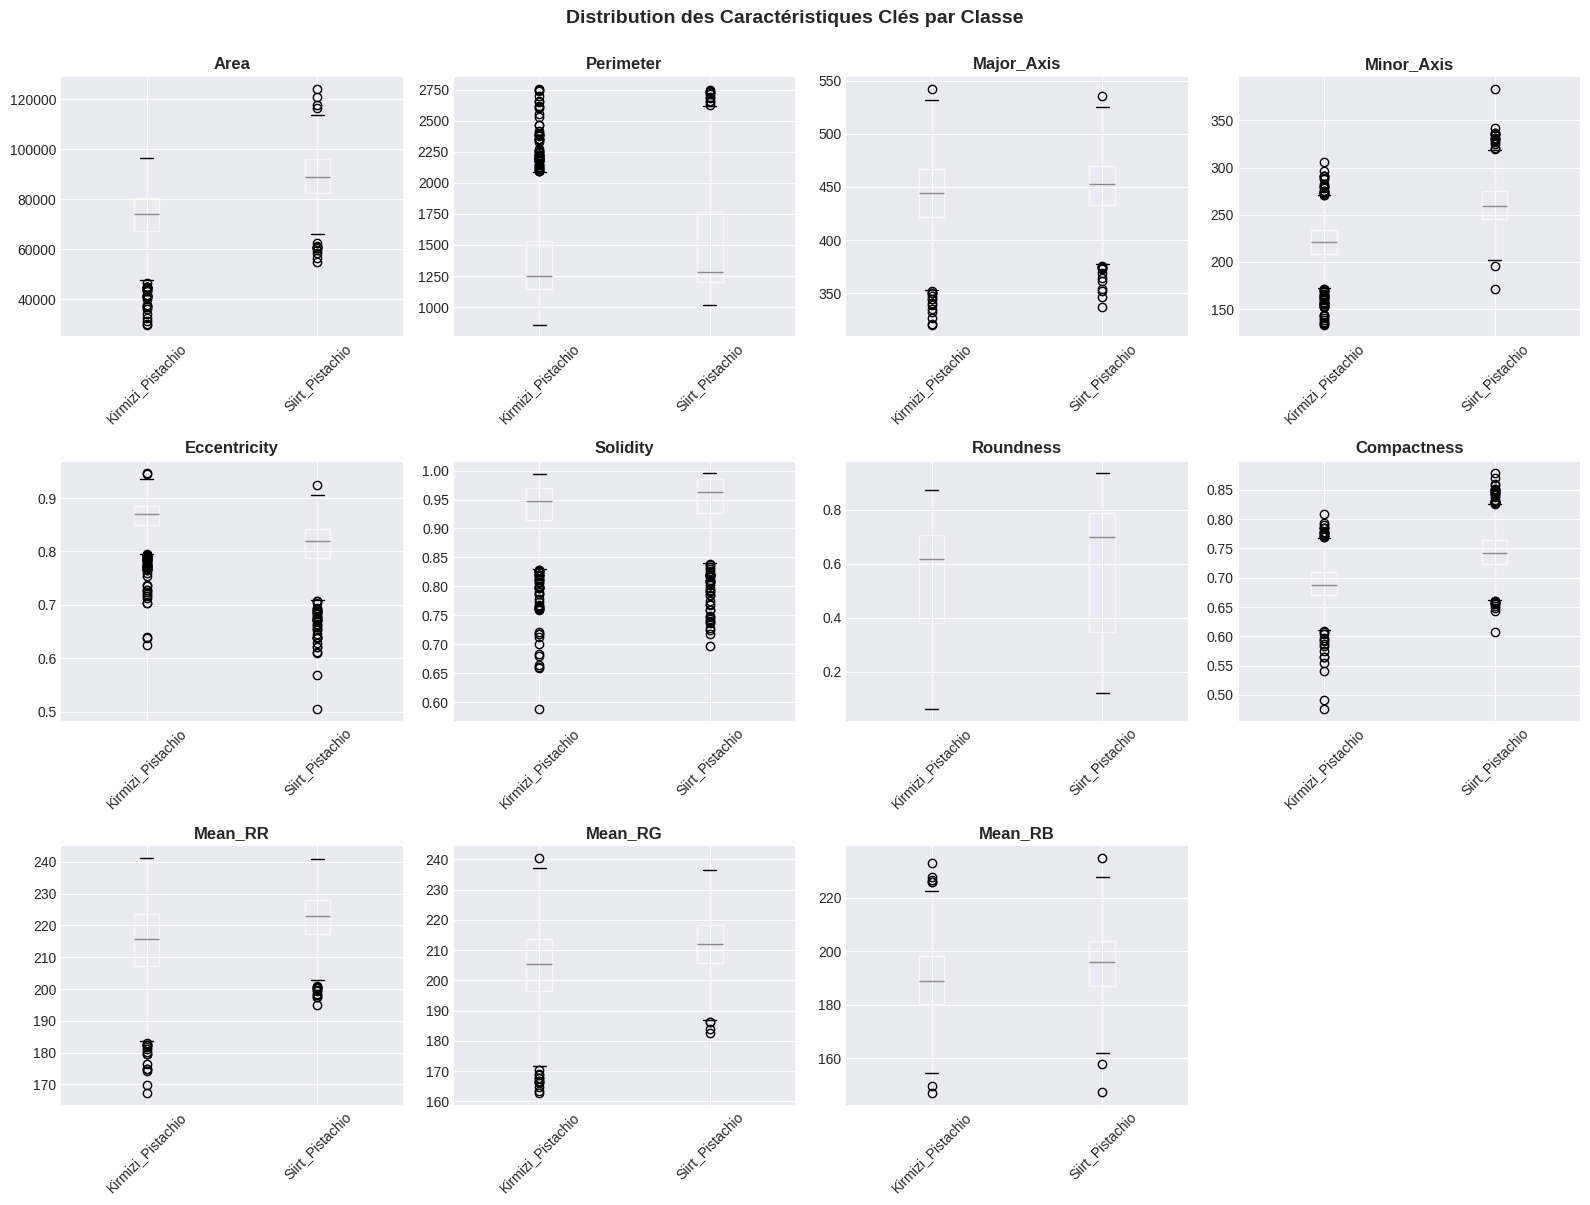

In [20]:
features = df.columns[:-1].tolist()

# Sélectionner quelques caractéristiques clés à visualiser
key_features = ['Area', 'Perimeter', 'Major_Axis', 'Minor_Axis', 'Eccentricity', 
                'Solidity', 'Roundness', 'Compactness', 'Mean_RR', 'Mean_RG', 'Mean_RB',"Kurtosis_RB"]

# Box plots pour les caractéristiques clés
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    df.boxplot(column=feature, by='Class', ax=axes[idx])
    axes[idx].set_title(feature, fontweight='bold')
    axes[idx].set_xlabel('')
    plt.sca(axes[idx])
    plt.xticks(rotation=45)

# Cacher le dernier subplot vide
axes[-1].set_visible(False)

plt.suptitle('Distribution des Caractéristiques Clés par Classe', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('boxplots_caracteristiques.png', dpi=300, bbox_inches='tight')
plt.show()

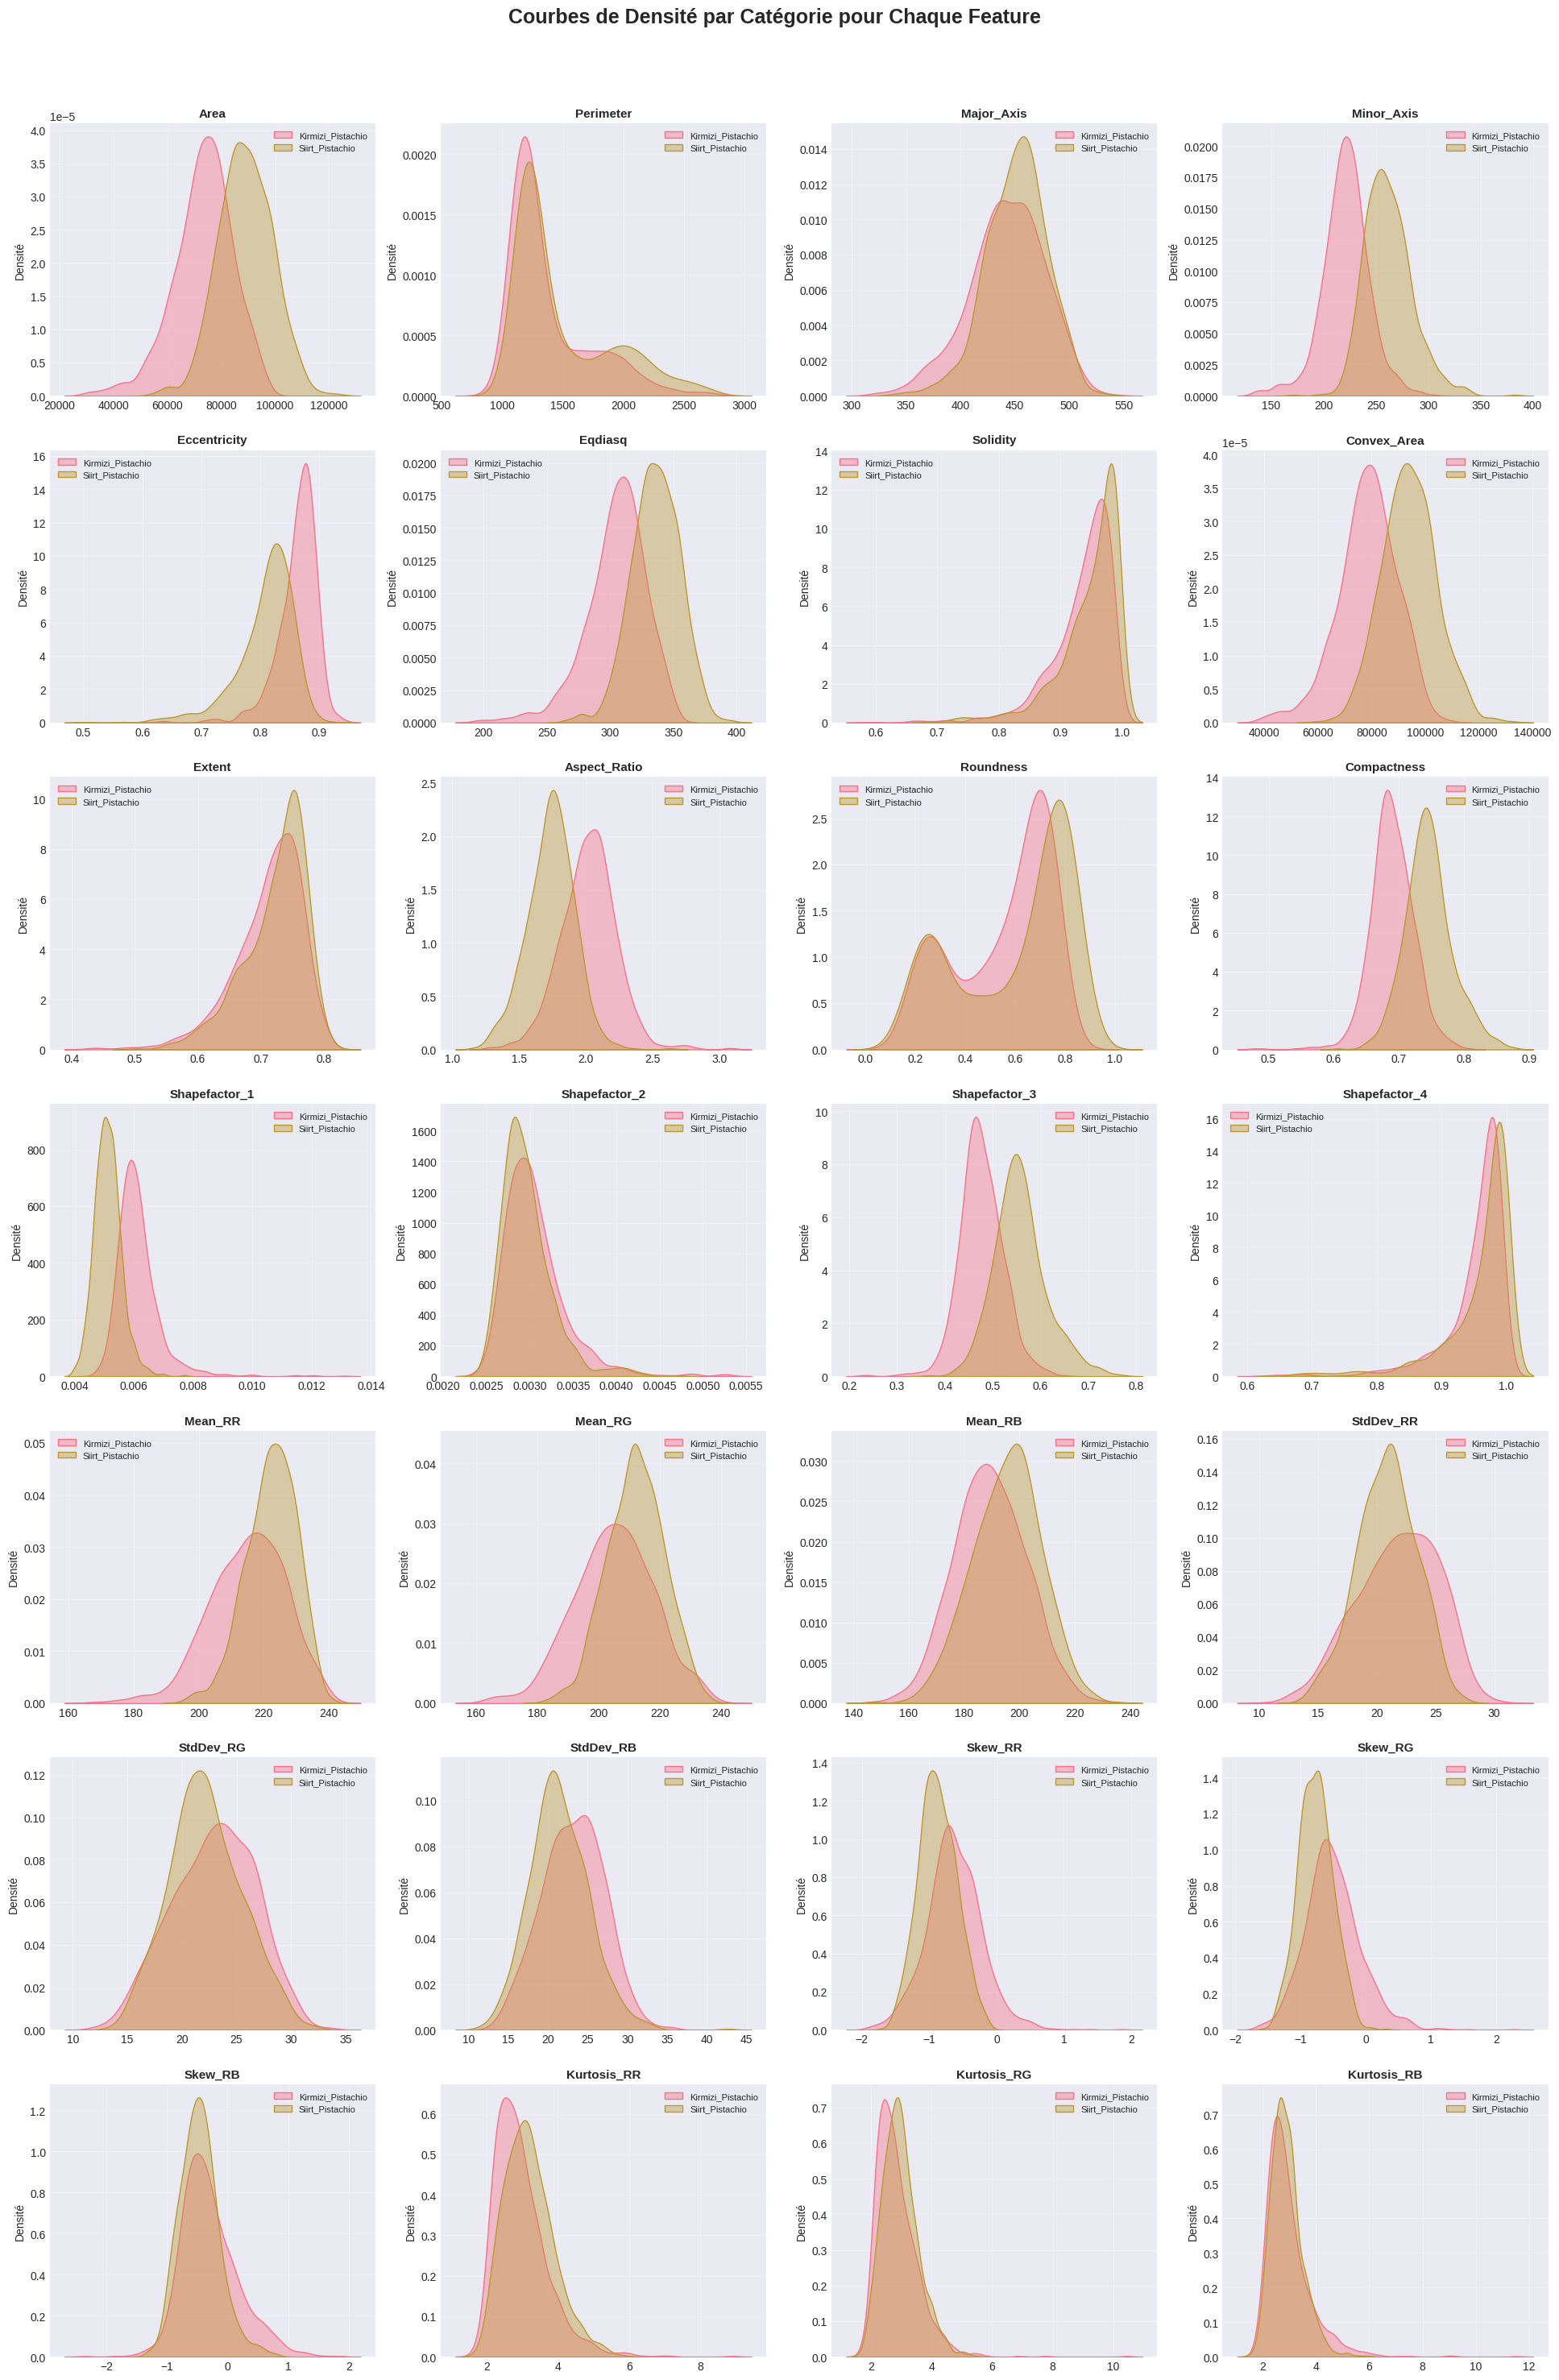

In [21]:
plt.figure(figsize=(24, 36))
n_cols = 4
n_rows = int(np.ceil(len(features) / n_cols))

for idx, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, idx + 1)
    for label in df['Class'].unique():
        sns.kdeplot(
            df[df['Class'] == label][feature],
            label=label,
            fill=True,
            alpha=0.4
        )
    plt.title(feature, fontsize=11, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Densité')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)

plt.suptitle('Courbes de Densité par Catégorie pour Chaque Feature', fontsize=18, fontweight='bold', y=0.92)
plt.show()

### 2.3 Distributions par Classe (Courbes de Densité)

Les courbes de densité KDE par classe permettent d'évaluer visuellement le pouvoir discriminant de chaque variable. Plusieurs caractéristiques morphologiques — notamment `Eccentricity`, `Solidity`, `Roundness`, `Compactness` ainsi que `Major_Axis` — présentent des distributions nettement séparées entre les deux variétés. En revanche, les caractéristiques colorimétriqu (canaux RVB moyens) offrent une discrimination plus nuancée, les distributions se chevauchant davantage. Cette observation suggère que les attributs de **forme** constituent les signaux les plus informatifs pour la tâche de classification.

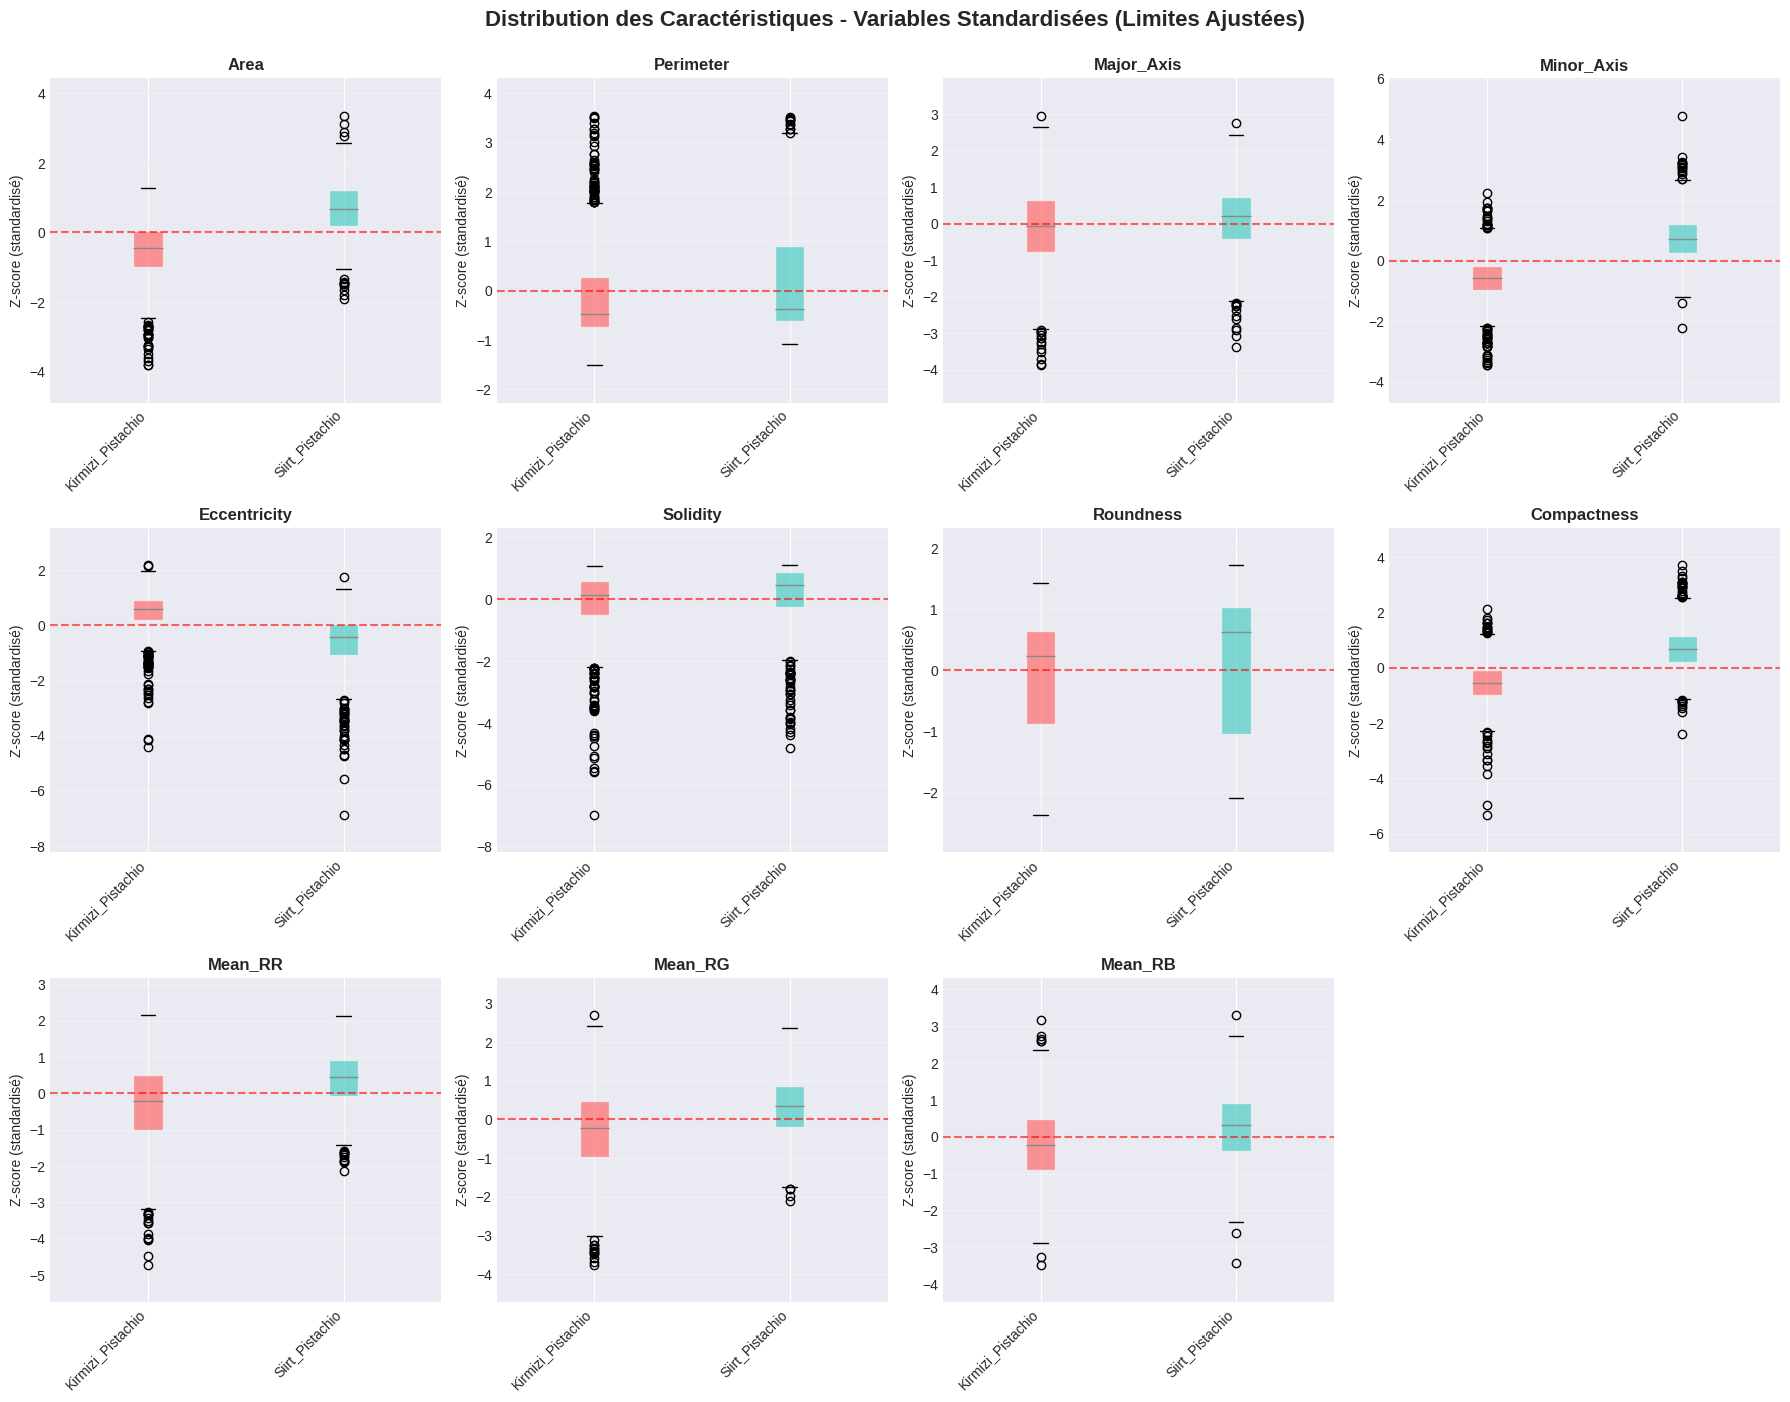

In [22]:
from sklearn.preprocessing import StandardScaler

features = df.columns[:-1].tolist()
key_features = ['Area', 'Perimeter', 'Major_Axis', 'Minor_Axis', 'Eccentricity', 
                'Solidity', 'Roundness', 'Compactness', 'Mean_RR', 'Mean_RG', 'Mean_RB']

# Standardisation
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

# Box plots avec LIMITES AJUSTÉES
fig, axes = plt.subplots(3, 4, figsize=(18, 14))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    # Créer le box plot
    bp = df_scaled.boxplot(column=feature, by='Class', ax=axes[idx],
                           patch_artist=True, return_type='dict')
    
    # Personnalisation des couleurs
    colors = ['#FF6B6B', '#4ECDC4']
    for patch, color in zip(bp[feature]['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Ligne de référence à 0
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.6)
    
    # AJUSTER LES LIMITES Y pour chaque feature
    data_min = df_scaled[feature].min()
    data_max = df_scaled[feature].max()
    margin = (data_max - data_min) * 0.15  # 15% de marge
    axes[idx].set_ylim(data_min - margin, data_max + margin)
    
    # Titres et labels
    axes[idx].set_title(f'{feature}', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Z-score (standardisé)', fontsize=10)
    plt.sca(axes[idx])
    plt.xticks(rotation=45, ha='right')
    
    # Grille
    axes[idx].grid(True, alpha=0.3, axis='y')

# Cacher le dernier subplot vide
axes[-1].set_visible(False)

plt.suptitle('Distribution des Caractéristiques - Variables Standardisées (Limites Ajustées)', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.savefig('boxplots_standardises_ajustes.png', dpi=300, bbox_inches='tight')
plt.show()

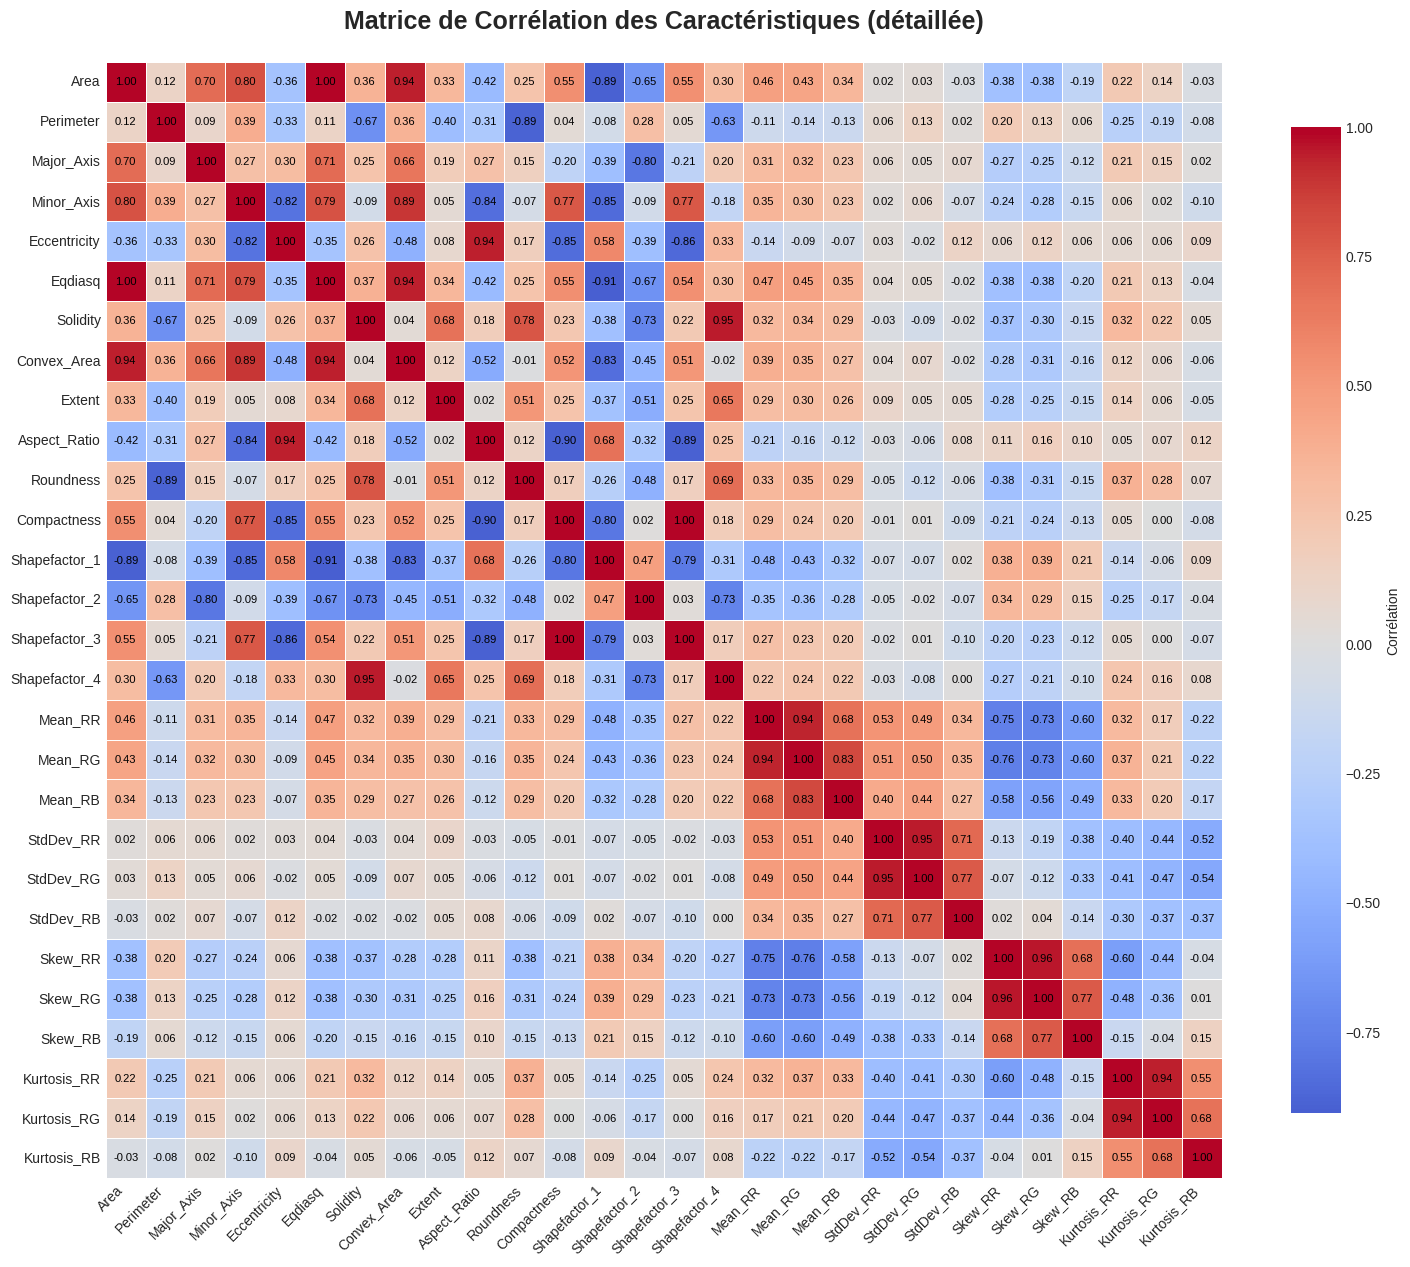

In [23]:
correlation_matrix = df[features].corr()
plt.figure(figsize=(18, 16))
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Corrélation"},
    square=True,
    annot_kws={"size": 8, "color": "black"}
)
plt.title('Matrice de Corrélation des Caractéristiques (détaillée)', fontsize=18, fontweight='bold', pad=24)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### 2.4 Analyse des Corrélations

La matrice de corrélation met en évidence plusieurs clusters de variables fortement corrélées entre elles :
- Les descripteurs de taille (`Area`, `Perimeter`, `Major_Axis`, `Convex_Area`, `Eqdiasq`) forment un groupe très inter-corrélé (corrélations > 0.9), ce qui indique une redondance partielle de l'information portée par ces variables.
- Les descripteurs de forme (`Solidity`, `Roundness`, `Compactness`, `Shapefactor_*`) présentent des corrélations intermédiaires.
- Les caractéristiques colorimétriques (canaux `Mean_RR/RG/RB`) sont également fortement corrélées entre elles.

Cette multicolinéarité importante aurait pu motiver l'application d'une Analyse en Composantes Principales (ACP) en amont. Toutefois, les réseaux de neurones profonds sont généralement capables d'apprendre des représentations internes compactes et de gérer implicitement la redondance via leurs couches cachées et la régularisation.

In [24]:
# Séparation des features et des labels
X = df[features].values
y = df['Class'].values

print(f"Shape des features: {X.shape}")
print(f"Shape des labels: {y.shape}")

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nClasses originales: {label_encoder.classes_}")
print(f"Mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# Séparer en train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y_encoded, 
    test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_seed'],
    stratify=y_encoded
)

# Séparer le train en train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=CONFIG['validation_split'], 
    random_state=CONFIG['random_seed'],
    stratify=y_train_full
)

print(f"\nTaille des ensembles:")
print(f"  Train: {X_train.shape[0]} échantillons")
print(f"  Validation: {X_val.shape[0]} échantillons")
print(f"  Test: {X_test.shape[0]} échantillons")

Shape des features: (2148, 28)
Shape des labels: (2148,)

Classes originales: ['Kirmizi_Pistachio' 'Siirt_Pistachio']
Mapping: {'Kirmizi_Pistachio': 0, 'Siirt_Pistachio': 1}

Taille des ensembles:
  Train: 1374 échantillons
  Validation: 344 échantillons
  Test: 430 échantillons


In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

---
## 3. Prétraitement et Partitionnement des Données

Les données sont divisées en trois ensembles distincts :
- **Entraînement** : 1 374 échantillons (64 %)
- **Validation** : 344 échantillons (16 %)
- **Test** : 430 échantillons (20 %)

La **standardisation** (moyenne = 0, écart-type = 1) est appliquée sur l'ensemble d'entraînement puis transférée à la validation et au test, conformément aux bonnes pratiques pour éviter toute fuite de données (*data leakage*). Les labels sont encodés numériquement : `Kirmizi_Pistachio → 0`, `Siirt_Pistachio → 1`.

In [26]:
def create_mlp_model(input_dim, hidden_layers=[128, 64, 32], 
                     dropout_rate=0.3, learning_rate=0.001, 
                     optimizer_name='adam', l2_reg=0.01):
    """
    Crée un modèle MLP (Multi-Layer Perceptron) pour la classification de pistaches
    
    Args:
        input_dim: Dimension des features d'entrée
        hidden_layers: Liste des tailles des couches cachées
        dropout_rate: Taux de dropout
        learning_rate: Taux d'apprentissage
        optimizer_name: Nom de l'optimizer ('adam', 'sgd', 'rmsprop', 'adamw')
        l2_reg: Coefficient de régularisation L2
    
    Returns:
        model: Modèle Keras compilé
    """
    # Initialisation
    model = models.Sequential(name='Pistachio_Classifier')
    
    # Couche d'entrée
    model.add(layers.Input(shape=(input_dim,)))
    
    # Couches cachées avec BatchNormalization et Dropout
    for i, units in enumerate(hidden_layers):
        model.add(layers.Dense(
            units, 
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(l2_reg),
            kernel_initializer='he_normal',
            name=f'hidden_{i+1}'
        ))
        model.add(layers.BatchNormalization(name=f'bn_{i+1}'))
        model.add(layers.Dropout(dropout_rate, name=f'dropout_{i+1}'))
    
    # Couche de sortie (classification binaire)
    model.add(layers.Dense(1, activation='sigmoid', name='output'))
    
    # Sélection de l'optimizer
    if optimizer_name == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_name == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adamw':
        optimizer = optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.01)
    else:
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    
    # Compilation
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    return model

In [27]:
# Fonction d'entraînement
def train_model(model, X_train, y_train, X_val, y_val, 
                epochs=100, batch_size=32, verbose=0, 
                early_stopping_patience=15):
    """
    Entraîne un modèle avec early stopping
    
    Returns:
        history: Historique d'entraînement
        best_epoch: Epoch avec la meilleure validation accuracy
    """
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=early_stopping_patience,
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=0
    )
    
    # Entraînement
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=verbose
    )
    
    # Trouver le meilleur epoch
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    
    return history, best_epoch

In [32]:
print("Entraînement d'un modèle de base...")
base_model = create_mlp_model(
    input_dim=CONFIG['n_features'],
    hidden_layers=[128, 64, 32],
    dropout_rate=0.3,
    learning_rate=0.001,
    optimizer_name='adam'
)

base_history, best_epoch= train_model(
    base_model, 
    X_train_scaled, y_train, 
    X_val_scaled, y_val,
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    verbose=1,
    early_stopping_patience=CONFIG['early_stopping_patience']
)

print(f"\nMeilleur epoch: {best_epoch}")
print(f"Meilleure validation accuracy: {max(base_history.history['val_accuracy']):.4f}")

Entraînement d'un modèle de base...
Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.6750 - loss: 4.9823 - precision_1: 0.6232 - recall_1: 0.6966 - val_accuracy: 0.8953 - val_loss: 4.1032 - val_precision_1: 0.8447 - val_recall_1: 0.9252 - learning_rate: 0.0010
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7854 - loss: 4.1888 - precision_1: 0.7570 - recall_1: 0.7691 - val_accuracy: 0.9099 - val_loss: 3.5061 - val_precision_1: 0.8867 - val_recall_1: 0.9048 - learning_rate: 0.0010
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8089 - loss: 3.5685 - precision_1: 0.8042 - recall_1: 0.7599 - val_accuracy: 0.9186 - val_loss: 3.0054 - val_precision_1: 0.8742 - val_recall_1: 0.9456 - learning_rate: 0.0010
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8219 - loss: 3.0683 - precision_1: 0.8009 - recall_1: 0.8042 - val_accuracy: 0.9360 - val_loss: 2.5653 - val_precision_1: 0.9310 - val_recall_1: 0.9184 - learning_rate: 0.

---
## 4. Modélisation — Réseau MLP de Base

### 4.1 Architecture et Résultats du Modèle de Référence

Le modèle de base adopte une architecture **MLP** (Multi-Layer Perceptron) à 3 couches cachées [128 → 64 → 32 neurones], avec un taux de dropout de 0,3 et l'optimiseur Adam (lr = 0,001). Ce modèle sert de référence (*baseline*) pour évaluer les gains apportés par les étapes ultérieures d'optimisation.

Les courbes d'apprentissage permettent d'apprécier la dynamique de convergence : une réduction progressive de la perte (loss) et une montée en précision sur les deux ensembles d'entraînement et de validation. Un écart modéré entre les courbes train et validation confirme l'absence de sur-apprentissage sévère à ce stade.

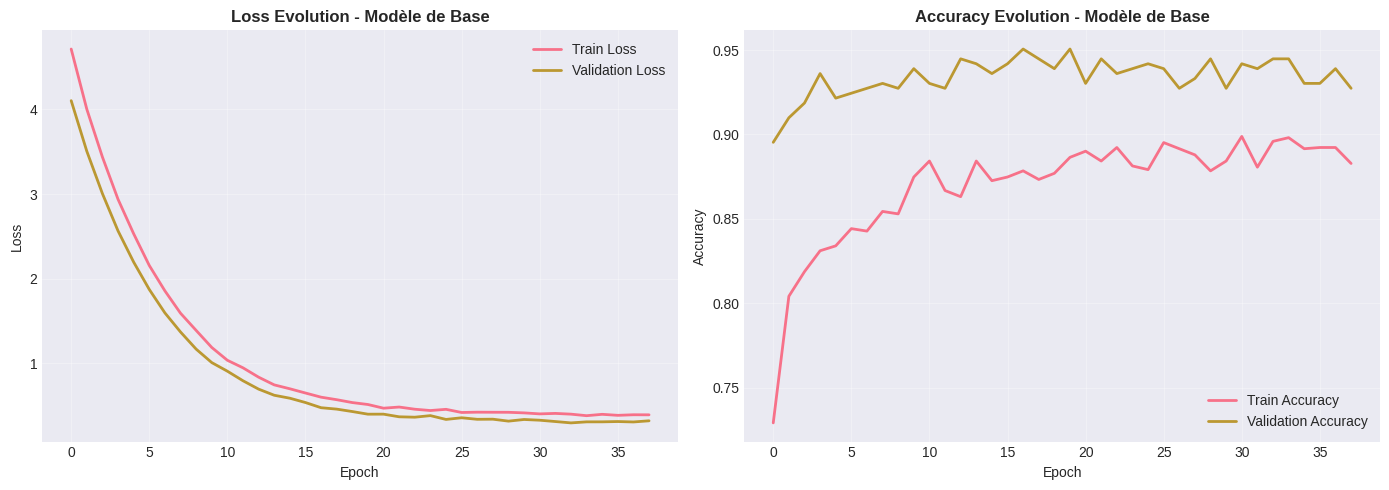

In [33]:
# Visualisation de l'entraînement
def plot_training_history(history, title_suffix=""):
    """
    Visualise l'historique d'entraînement
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title(f'Loss Evolution {title_suffix}', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title(f'Accuracy Evolution {title_suffix}', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

fig = plot_training_history(base_history, "- Modèle de Base")
plt.savefig('training_history_base.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# Expérimentation avec différents learning rates
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
lr_results = {}

print("Expérimentation avec différents learning rates...\n")

for lr in learning_rates:
    print(f"\nLearning Rate: {lr}")
    
    model = create_mlp_model(
        input_dim=CONFIG['n_features'],
        learning_rate=lr,
        optimizer_name='adam'
    )
    
    history, best_epoch = train_model(
        model, 
        X_train_scaled, y_train, 
        X_val_scaled, y_val,
        epochs=50,
        verbose=0
    )
    
    lr_results[lr] = {
        'history': history,
        'best_epoch': best_epoch,
        'best_val_acc': max(history.history['val_accuracy']),
        'best_val_loss': min(history.history['val_loss'])
    }
    
    print(f"  Meilleur epoch: {best_epoch}")
    print(f"  Validation accuracy: {lr_results[lr]['best_val_acc']:.4f}")
    print(f"  Validation loss: {lr_results[lr]['best_val_loss']:.4f}")

print("\nExpérimentation terminée!")

Expérimentation avec différents learning rates...


Learning Rate: 0.0001
  Meilleur epoch: 42
  Validation accuracy: 0.9302
  Validation loss: 2.7076

Learning Rate: 0.0005
  Meilleur epoch: 46
  Validation accuracy: 0.9564
  Validation loss: 0.4252

Learning Rate: 0.001
  Meilleur epoch: 25
  Validation accuracy: 0.9535
  Validation loss: 0.2787

Learning Rate: 0.005
  Meilleur epoch: 47
  Validation accuracy: 0.9535
  Validation loss: 0.1919

Learning Rate: 0.01
  Meilleur epoch: 42
  Validation accuracy: 0.9593
  Validation loss: 0.1853

Expérimentation terminée!


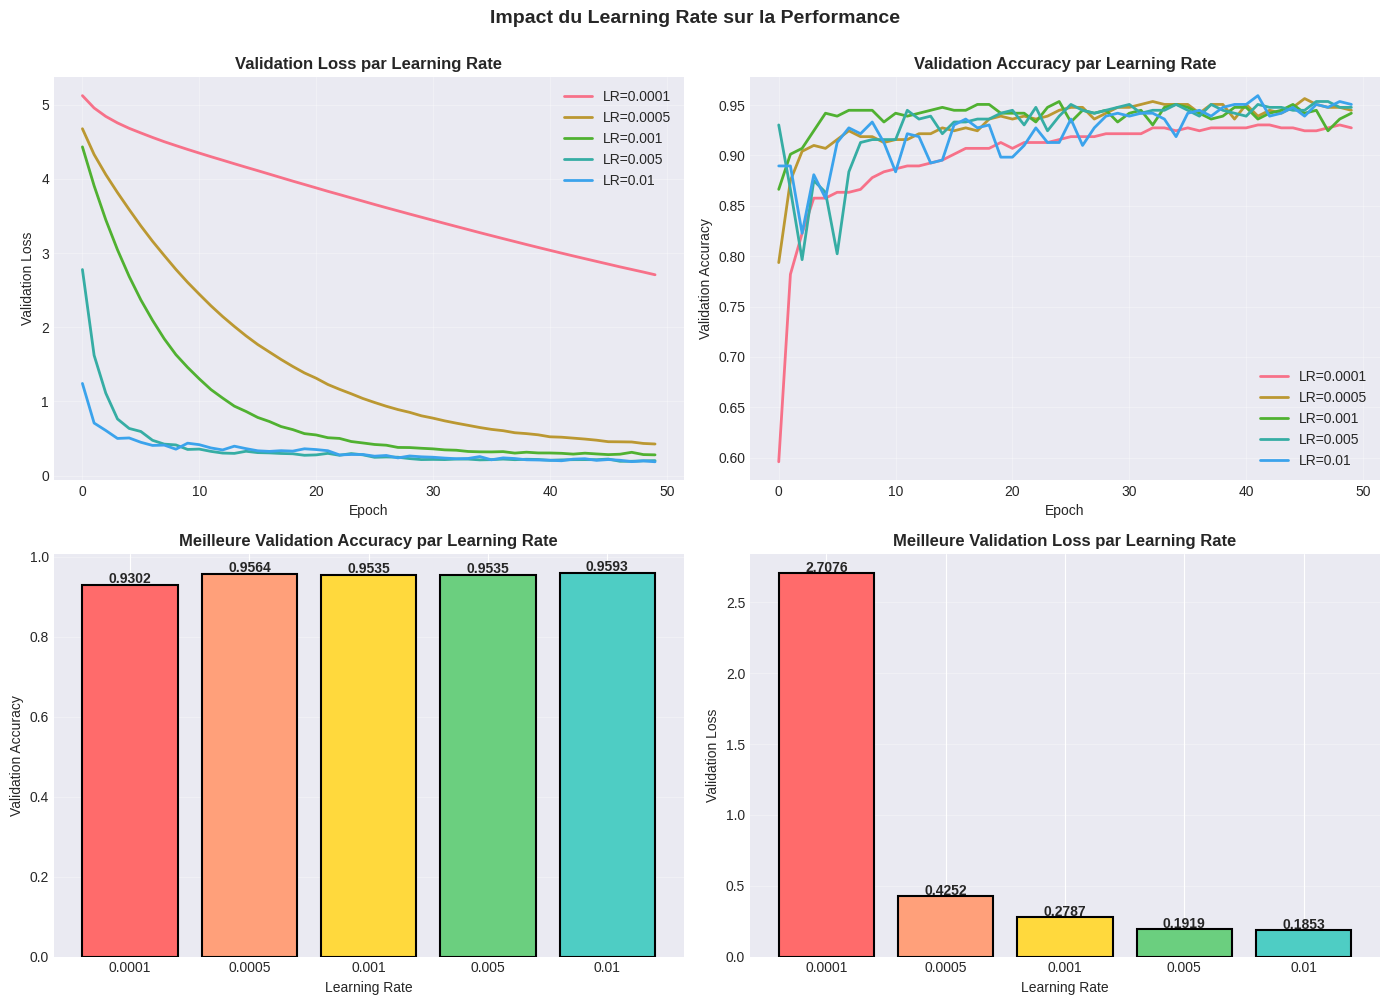

In [35]:
# Visualisation de l'impact du learning rate
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss évolution pour tous les LR
ax = axes[0, 0]
for lr in learning_rates:
    history = lr_results[lr]['history']
    ax.plot(history.history['val_loss'], label=f'LR={lr}', linewidth=2)
ax.set_title('Validation Loss par Learning Rate', fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Accuracy évolution pour tous les LR
ax = axes[0, 1]
for lr in learning_rates:
    history = lr_results[lr]['history']
    ax.plot(history.history['val_accuracy'], label=f'LR={lr}', linewidth=2)
ax.set_title('Validation Accuracy par Learning Rate', fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Meilleure accuracy par LR
ax = axes[1, 0]
best_accs = [lr_results[lr]['best_val_acc'] for lr in learning_rates]
colors_lr = ['#FF6B6B', '#FFA07A', '#FFD93D', '#6BCF7F', '#4ECDC4']
ax.bar(range(len(learning_rates)), best_accs, color=colors_lr, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(learning_rates)))
ax.set_xticklabels([str(lr) for lr in learning_rates])
ax.set_title('Meilleure Validation Accuracy par Learning Rate', fontweight='bold')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Accuracy')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(best_accs):
    ax.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# Meilleure loss par LR
ax = axes[1, 1]
best_losses = [lr_results[lr]['best_val_loss'] for lr in learning_rates]
ax.bar(range(len(learning_rates)), best_losses, color=colors_lr, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(learning_rates)))
ax.set_xticklabels([str(lr) for lr in learning_rates])
ax.set_title('Meilleure Validation Loss par Learning Rate', fontweight='bold')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(best_losses):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

plt.suptitle('Impact du Learning Rate sur la Performance', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('learning_rate_impact.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Impact du Taux d'Apprentissage (*Learning Rate*)

Cinq valeurs de taux d'apprentissage ont été testées : 0.0001, 0.0005, 0.001, 0.005 et 0.01.

| Learning Rate | Val. Accuracy | Val. Loss |
|:---:|:---:|:---:|
| 0.0001 | 93.02 % | 2.7076 |
| 0.0005 | 95.64 % | 0.4252 |
| 0.001 | 95.35 % | 0.2787 |
| 0.005 | 95.35 % | 0.1919 |
| 0.01 | **95.93 %** | **0.1853** |

Un taux trop faible (0.0001) ralentit considérablement la convergence et dégrade la précision finale. À l'inverse, des valeurs comprises entre 0.005 et 0.01 permettent d'atteindre les meilleures performances, avec des pertes de validation plus basses. **La valeur lr = 0.01 s'avère la plus performante** sur cet ensemble de données, atteignant 95.93 % de précision en validation.

In [38]:
# Expérimentation avec différents optimizers
optimizers_list = ['adam', 'sgd', 'rmsprop', 'adamw']
optimizer_results = {}

print("Comparaison des optimizers...\n")

for opt in optimizers_list:
    print(f"\nOptimizer: {opt.upper()}")
    
    model = create_mlp_model(
        input_dim=CONFIG['n_features'],
        learning_rate=0.01, # Meilleur learning rate
        optimizer_name=opt
    )
    
    history, best_epoch = train_model(
        model, 
        X_train_scaled, y_train, 
        X_val_scaled, y_val,
        epochs=50,
        verbose=0
    )
    
    optimizer_results[opt] = {
        'history': history,
        'best_epoch': best_epoch,
        'best_val_acc': max(history.history['val_accuracy']),
        'best_val_loss': min(history.history['val_loss']),
        'training_time': len(history.history['loss'])
    }
    
    print(f"  Meilleur epoch: {best_epoch}")
    print(f"  Validation accuracy: {optimizer_results[opt]['best_val_acc']:.4f}")
    print(f"  Validation loss: {optimizer_results[opt]['best_val_loss']:.4f}")

print("\nComparaison terminée!")

Comparaison des optimizers...


Optimizer: ADAM
  Meilleur epoch: 44
  Validation accuracy: 0.9564
  Validation loss: 0.1791

Optimizer: SGD
  Meilleur epoch: 33
  Validation accuracy: 0.9564
  Validation loss: 0.2423

Optimizer: RMSPROP
  Meilleur epoch: 38
  Validation accuracy: 0.9622
  Validation loss: 0.1639

Optimizer: ADAMW
  Meilleur epoch: 42
  Validation accuracy: 0.9535
  Validation loss: 0.1779

Comparaison terminée!


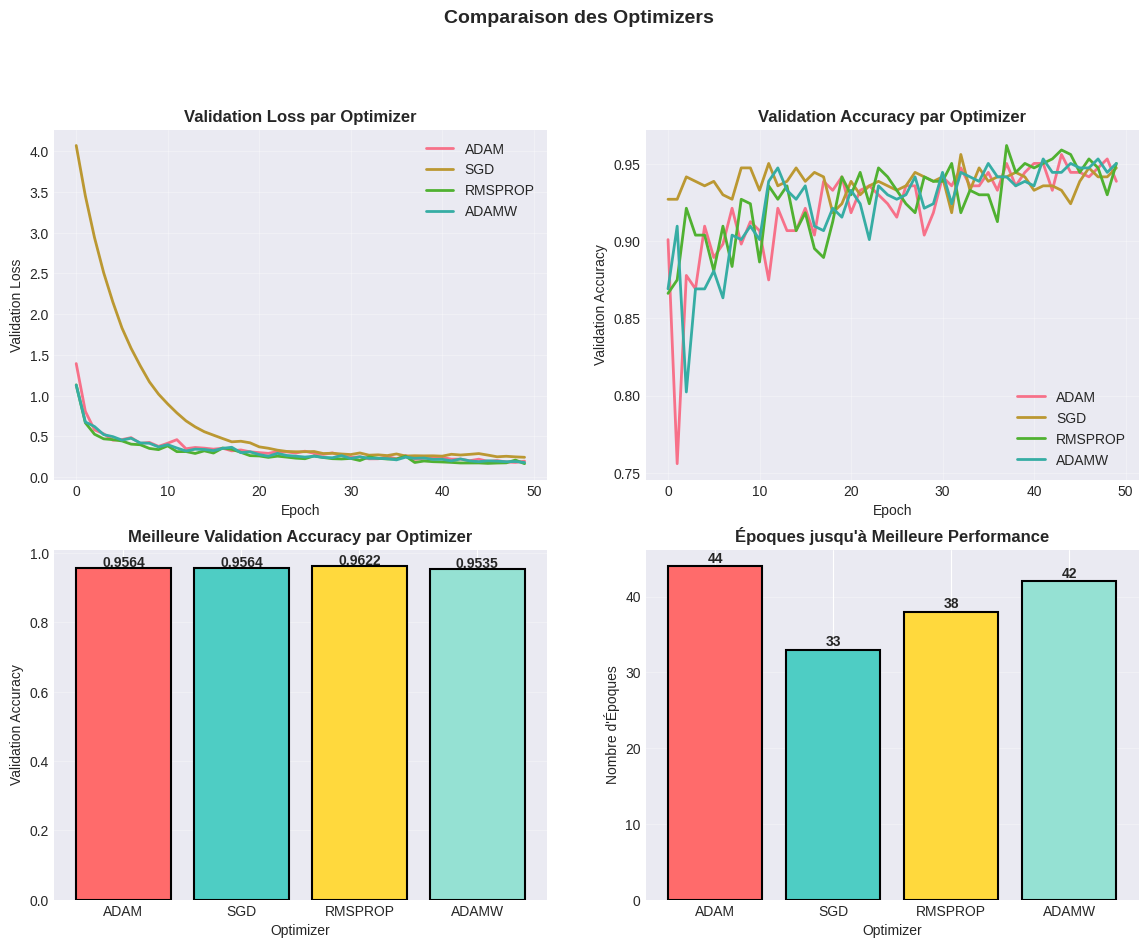

In [39]:
# Visualisation de la comparaison des optimizers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss évolution pour tous les optimizers
ax = axes[0, 0]
for opt in optimizers_list:
    history = optimizer_results[opt]['history']
    ax.plot(history.history['val_loss'], label=opt.upper(), linewidth=2)
ax.set_title('Validation Loss par Optimizer', fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Accuracy évolution pour tous les optimizers
ax = axes[0, 1]
for opt in optimizers_list:
    history = optimizer_results[opt]['history']
    ax.plot(history.history['val_accuracy'], label=opt.upper(), linewidth=2)
ax.set_title('Validation Accuracy par Optimizer', fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Meilleure accuracy par optimizer
ax = axes[1, 0]
best_accs = [optimizer_results[opt]['best_val_acc'] for opt in optimizers_list]
colors_opt = ['#FF6B6B', '#4ECDC4', '#FFD93D', '#95E1D3']
ax.bar(range(len(optimizers_list)), best_accs, color=colors_opt, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(optimizers_list)))
ax.set_xticklabels([opt.upper() for opt in optimizers_list])
ax.set_title('Meilleure Validation Accuracy par Optimizer', fontweight='bold')
ax.set_xlabel('Optimizer')
ax.set_ylabel('Validation Accuracy')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(best_accs):
    ax.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# Epochs jusqu'à convergence
ax = axes[1, 1]
epochs_to_conv = [optimizer_results[opt]['best_epoch'] for opt in optimizers_list]
ax.bar(range(len(optimizers_list)), epochs_to_conv, color=colors_opt, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(optimizers_list)))
ax.set_xticklabels([opt.upper() for opt in optimizers_list])
ax.set_title('Époques jusqu\'à Meilleure Performance', fontweight='bold')
ax.set_xlabel('Optimizer')
ax.set_ylabel('Nombre d\'Époques')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(epochs_to_conv):
    ax.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.suptitle('Comparaison des Optimizers', fontsize=14, fontweight='bold', y=1.00)
plt.show()

### 4.3 Comparaison des Optimiseurs

Quatre optimiseurs classiques ont été mis en compétition dans des conditions identiques :

| Optimiseur | Val. Accuracy | Val. Loss | Meilleure Époque |
|:---:|:---:|:---:|:---:|
| Adam | 95.64 % | 0.1791 | 44 |
| SGD | 95.64 % | 0.2423 | 33 |
| **RMSprop** | **96.22 %** | **0.1639** | 38 |
| AdamW | 95.35 % | 0.1779 | 42 |

**RMSprop se démarque** avec la meilleure précision de validation (96.22 %) et la perte la plus faible. Adam et SGD atteignent des performances équivalentes, tandis qu'AdamW se révèle légèrement en retrait malgré son mécanisme de décroissance des poids intégré. Ce résultat plaide en faveur de l'utilisation de RMSprop comme optimiseur de référence pour la suite des expérimentations.

In [40]:
# Expérimentation avec différentes valeurs de L2 regularization
print("=== Expérimentation: Impact de la Régularisation L2 ===\n")

l2_values = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 5e-2]
l2_results = {}

for l2_reg in l2_values:
    print(f"\nL2 Regularization: {l2_reg}")
    
    model = create_mlp_model(
        input_dim=CONFIG['n_features'],
        hidden_layers=[128, 64, 32],
        dropout_rate=0.3,
        learning_rate=0.01, # Meilleir learning rate
        optimizer_name='rmsprop', # meilleur optimizer trouve
        l2_reg=l2_reg
    )
    
    history, best_epoch = train_model(
        model, 
        X_train_scaled, y_train, 
        X_val_scaled, y_val,
        epochs=50,
        verbose=0
    )
    
    # Calculer l'écart train-val (overfitting indicator)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    overfitting_gap = np.mean([train_acc[i] - val_acc[i] for i in range(len(val_acc))])
    
    l2_results[l2_reg] = {
        'history': history,
        'best_epoch': best_epoch,
        'best_val_acc': max(history.history['val_accuracy']),
        'best_val_loss': min(history.history['val_loss']),
        'final_train_acc': history.history['accuracy'][-1],
        'final_val_acc': history.history['val_accuracy'][-1],
        'overfitting_gap': overfitting_gap
    }
    
    print(f"  Meilleur epoch: {best_epoch}")
    print(f"  Validation accuracy: {l2_results[l2_reg]['best_val_acc']:.4f}")
    print(f"  Train-Val gap (overfitting): {overfitting_gap:.4f}")

print("\n=== Expérimentation L2 terminée ===")

=== Expérimentation: Impact de la Régularisation L2 ===


L2 Regularization: 0.0
  Meilleur epoch: 10
  Validation accuracy: 0.9564
  Train-Val gap (overfitting): 0.0014

L2 Regularization: 1e-05
  Meilleur epoch: 12
  Validation accuracy: 0.9593
  Train-Val gap (overfitting): -0.0073

L2 Regularization: 0.0001
  Meilleur epoch: 19
  Validation accuracy: 0.9535
  Train-Val gap (overfitting): 0.0028

L2 Regularization: 0.001
  Meilleur epoch: 14
  Validation accuracy: 0.9622
  Train-Val gap (overfitting): -0.0120

L2 Regularization: 0.01
  Meilleur epoch: 38
  Validation accuracy: 0.9477
  Train-Val gap (overfitting): -0.0221

L2 Regularization: 0.05
  Meilleur epoch: 50
  Validation accuracy: 0.9448
  Train-Val gap (overfitting): -0.0274

=== Expérimentation L2 terminée ===


In [42]:
# Comparaison: rmsprop vs AdamW avec L2
# Fonction modifiée pour accepter weight_decay dans AdamW
def create_mlp_model_with_wd(input_dim, hidden_layers=[128, 64, 32], 
                              dropout_rate=0.3, learning_rate=0.01, 
                              optimizer_name='rmsprop', l2_reg=0.001, weight_decay=None):
    """
    Version étendue avec support explicite du weight_decay pour AdamW
    """
    model = models.Sequential(name='Pistachio_Classifier_WD')
    model.add(layers.Input(shape=(input_dim,)))
    
    for i, units in enumerate(hidden_layers):
        model.add(layers.Dense(
            units, 
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(l2_reg),
            kernel_initializer='he_normal',
            name=f'hidden_{i+1}'
        ))
        model.add(layers.BatchNormalization(name=f'bn_{i+1}'))
        model.add(layers.Dropout(dropout_rate, name=f'dropout_{i+1}'))
    
    model.add(layers.Dense(1, activation='sigmoid', name='output'))
    
    # Sélection de l'optimizer avec weight_decay explicite pour AdamW
    if optimizer_name == 'adamw' and weight_decay is not None:
        optimizer = optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'adamw':
        optimizer = optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.01)
    elif optimizer_name == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    return model

# Test avec différentes valeurs de weight_decay pour AdamW
weight_decay_values = [0.0, 1e-4, 1e-3, 1e-2, 5e-2]
adamw_results = {}

for wd in weight_decay_values:
    print(f"\nAdamW Weight Decay: {wd}")
    
    model = create_mlp_model_with_wd(
        input_dim=CONFIG['n_features'],
        hidden_layers=[128, 64, 32],
        dropout_rate=0.3,
        learning_rate=0.01,
        optimizer_name='adamw',
        l2_reg=0.0,  # Pas de L2 pour isoler l'effet du weight decay
        weight_decay=wd
    )
    
    history, best_epoch = train_model(
        model, 
        X_train_scaled, y_train, 
        X_val_scaled, y_val,
        epochs=50,
        verbose=0
    )
    
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    overfitting_gap = np.mean([train_acc[i] - val_acc[i] for i in range(len(val_acc))])
    
    adamw_results[wd] = {
        'history': history,
        'best_epoch': best_epoch,
        'best_val_acc': max(history.history['val_accuracy']),
        'best_val_loss': min(history.history['val_loss']),
        'final_train_acc': history.history['accuracy'][-1],
        'final_val_acc': history.history['val_accuracy'][-1],
        'overfitting_gap': overfitting_gap
    }
    
    print(f"  Meilleur epoch: {best_epoch}")
    print(f"  Validation accuracy: {adamw_results[wd]['best_val_acc']:.4f}")
    print(f"  Train-Val gap (overfitting): {overfitting_gap:.4f}")

print("\n=== Comparaison AdamW terminée ===")


AdamW Weight Decay: 0.0
  Meilleur epoch: 9
  Validation accuracy: 0.9506
  Train-Val gap (overfitting): -0.0159

AdamW Weight Decay: 0.0001
  Meilleur epoch: 9
  Validation accuracy: 0.9477
  Train-Val gap (overfitting): -0.0098

AdamW Weight Decay: 0.001
  Meilleur epoch: 17
  Validation accuracy: 0.9535
  Train-Val gap (overfitting): -0.0120

AdamW Weight Decay: 0.01
  Meilleur epoch: 11
  Validation accuracy: 0.9564
  Train-Val gap (overfitting): -0.0216

AdamW Weight Decay: 0.05
  Meilleur epoch: 20
  Validation accuracy: 0.9477
  Train-Val gap (overfitting): -0.0089

=== Comparaison AdamW terminée ===


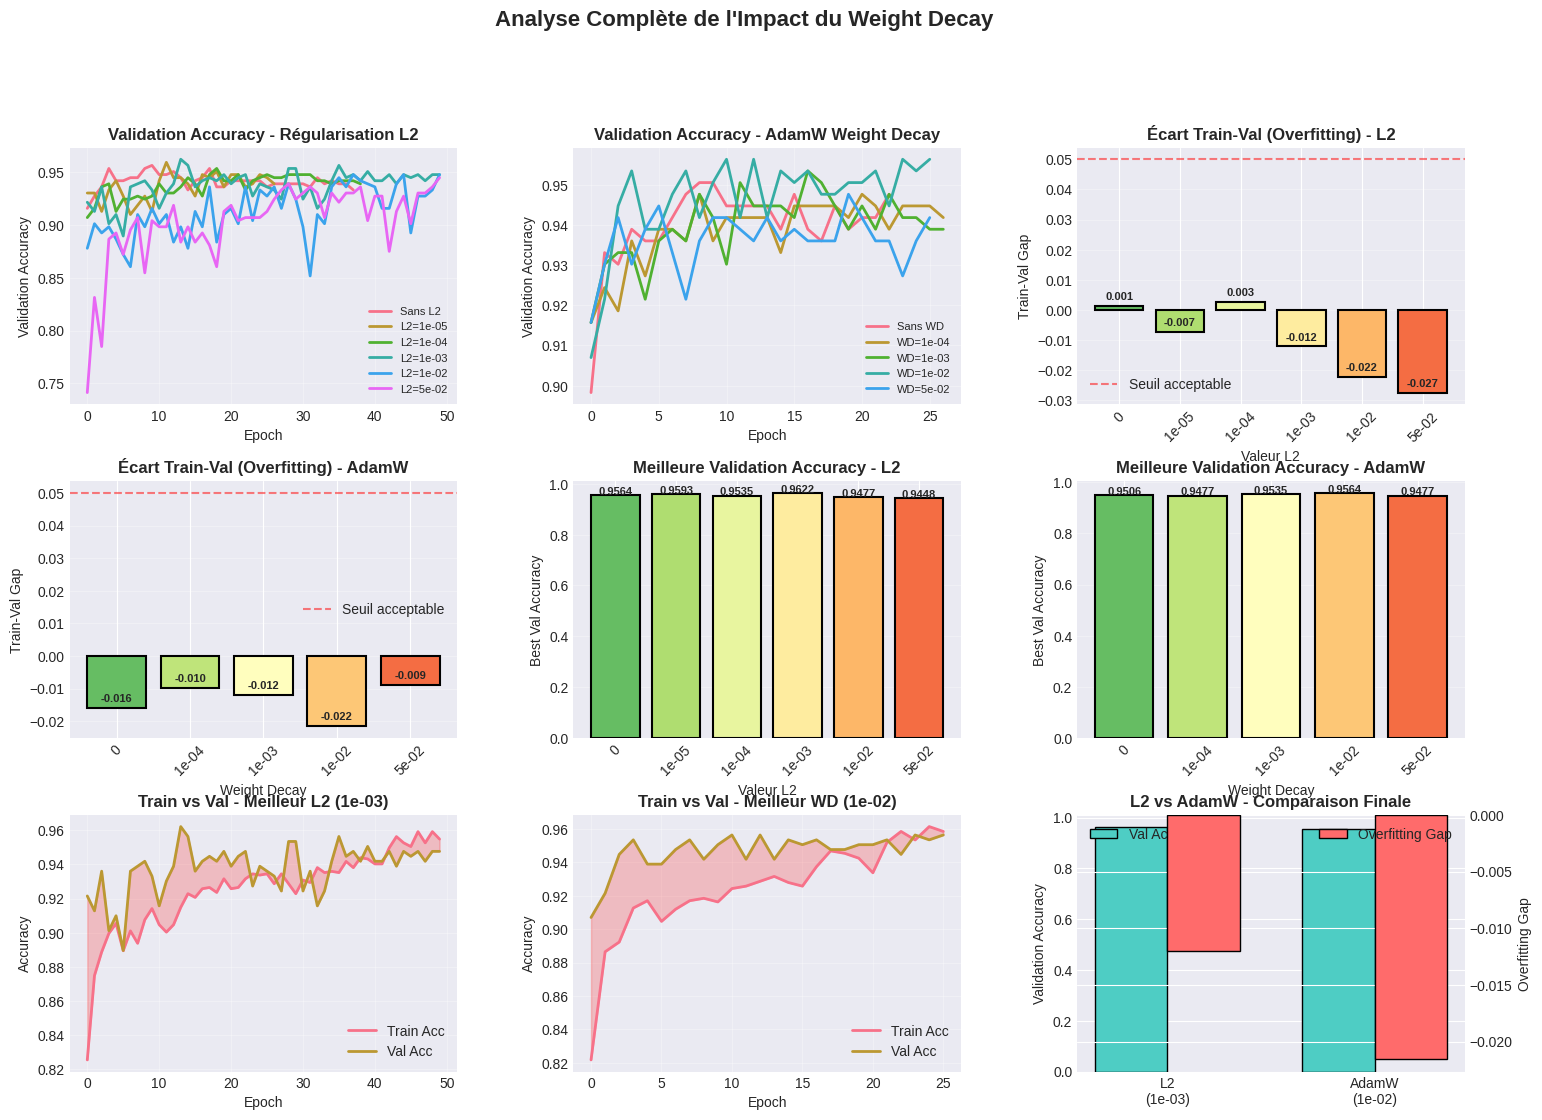


Visualisations sauvegardées: weight_decay_analysis.png


In [43]:
# Visualisation de l'impact du Weight Decay
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Courbes de validation accuracy pour L2
ax1 = fig.add_subplot(gs[0, 0])
for l2_reg in l2_values:
    history = l2_results[l2_reg]['history']
    label = f'L2={l2_reg:.0e}' if l2_reg != 0 else 'Sans L2'
    ax1.plot(history.history['val_accuracy'], label=label, linewidth=2)
ax1.set_title('Validation Accuracy - Régularisation L2', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Accuracy')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Courbes de validation accuracy pour AdamW
ax2 = fig.add_subplot(gs[0, 1])
for wd in weight_decay_values:
    history = adamw_results[wd]['history']
    label = f'WD={wd:.0e}' if wd != 0 else 'Sans WD'
    ax2.plot(history.history['val_accuracy'], label=label, linewidth=2)
ax2.set_title('Validation Accuracy - AdamW Weight Decay', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Overfitting Gap (Train - Val) pour L2
ax3 = fig.add_subplot(gs[0, 2])
colors_l2 = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(l2_values)))
overfitting_gaps_l2 = [l2_results[l2]['overfitting_gap'] for l2 in l2_values]
labels_l2 = [f'{l2:.0e}' if l2 != 0 else '0' for l2 in l2_values]
bars = ax3.bar(range(len(l2_values)), overfitting_gaps_l2, color=colors_l2, edgecolor='black', linewidth=1.5)
ax3.set_xticks(range(len(l2_values)))
ax3.set_xticklabels(labels_l2, rotation=45)
ax3.set_title('Écart Train-Val (Overfitting) - L2', fontweight='bold')
ax3.set_xlabel('Valeur L2')
ax3.set_ylabel('Train-Val Gap')
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='Seuil acceptable')
ax3.legend()
for i, v in enumerate(overfitting_gaps_l2):
    ax3.text(i, v + 0.002, f'{v:.3f}', ha='center', fontsize=8, fontweight='bold')

# 4. Overfitting Gap pour AdamW
ax4 = fig.add_subplot(gs[1, 0])
colors_wd = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(weight_decay_values)))
overfitting_gaps_wd = [adamw_results[wd]['overfitting_gap'] for wd in weight_decay_values]
labels_wd = [f'{wd:.0e}' if wd != 0 else '0' for wd in weight_decay_values]
bars = ax4.bar(range(len(weight_decay_values)), overfitting_gaps_wd, color=colors_wd, edgecolor='black', linewidth=1.5)
ax4.set_xticks(range(len(weight_decay_values)))
ax4.set_xticklabels(labels_wd, rotation=45)
ax4.set_title('Écart Train-Val (Overfitting) - AdamW', fontweight='bold')
ax4.set_xlabel('Weight Decay')
ax4.set_ylabel('Train-Val Gap')
ax4.grid(True, alpha=0.3, axis='y')
ax4.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='Seuil acceptable')
ax4.legend()
for i, v in enumerate(overfitting_gaps_wd):
    ax4.text(i, v + 0.002, f'{v:.3f}', ha='center', fontsize=8, fontweight='bold')

# 5. Meilleure Val Accuracy - L2
ax5 = fig.add_subplot(gs[1, 1])
best_val_accs_l2 = [l2_results[l2]['best_val_acc'] for l2 in l2_values]
bars = ax5.bar(range(len(l2_values)), best_val_accs_l2, color=colors_l2, edgecolor='black', linewidth=1.5)
ax5.set_xticks(range(len(l2_values)))
ax5.set_xticklabels(labels_l2, rotation=45)
ax5.set_title('Meilleure Validation Accuracy - L2', fontweight='bold')
ax5.set_xlabel('Valeur L2')
ax5.set_ylabel('Best Val Accuracy')
ax5.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(best_val_accs_l2):
    ax5.text(i, v + 0.003, f'{v:.4f}', ha='center', fontsize=8, fontweight='bold')

# 6. Meilleure Val Accuracy - AdamW
ax6 = fig.add_subplot(gs[1, 2])
best_val_accs_wd = [adamw_results[wd]['best_val_acc'] for wd in weight_decay_values]
bars = ax6.bar(range(len(weight_decay_values)), best_val_accs_wd, color=colors_wd, edgecolor='black', linewidth=1.5)
ax6.set_xticks(range(len(weight_decay_values)))
ax6.set_xticklabels(labels_wd, rotation=45)
ax6.set_title('Meilleure Validation Accuracy - AdamW', fontweight='bold')
ax6.set_xlabel('Weight Decay')
ax6.set_ylabel('Best Val Accuracy')
ax6.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(best_val_accs_wd):
    ax6.text(i, v + 0.003, f'{v:.4f}', ha='center', fontsize=8, fontweight='bold')

# 7. Comparaison Train vs Val pour meilleur L2
ax7 = fig.add_subplot(gs[2, 0])
best_l2 = max(l2_results.keys(), key=lambda x: l2_results[x]['best_val_acc'])
history_best_l2 = l2_results[best_l2]['history']
ax7.plot(history_best_l2.history['accuracy'], label='Train Acc', linewidth=2)
ax7.plot(history_best_l2.history['val_accuracy'], label='Val Acc', linewidth=2)
ax7.fill_between(range(len(history_best_l2.history['accuracy'])), 
                 history_best_l2.history['accuracy'], 
                 history_best_l2.history['val_accuracy'], 
                 alpha=0.2, color='red')
ax7.set_title(f'Train vs Val - Meilleur L2 ({best_l2:.0e})', fontweight='bold')
ax7.set_xlabel('Epoch')
ax7.set_ylabel('Accuracy')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Comparaison Train vs Val pour meilleur AdamW
ax8 = fig.add_subplot(gs[2, 1])
best_wd = max(adamw_results.keys(), key=lambda x: adamw_results[x]['best_val_acc'])
history_best_wd = adamw_results[best_wd]['history']
ax8.plot(history_best_wd.history['accuracy'], label='Train Acc', linewidth=2)
ax8.plot(history_best_wd.history['val_accuracy'], label='Val Acc', linewidth=2)
ax8.fill_between(range(len(history_best_wd.history['accuracy'])), 
                 history_best_wd.history['accuracy'], 
                 history_best_wd.history['val_accuracy'], 
                 alpha=0.2, color='red')
ax8.set_title(f'Train vs Val - Meilleur WD ({best_wd:.0e})', fontweight='bold')
ax8.set_xlabel('Epoch')
ax8.set_ylabel('Accuracy')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Comparaison directe L2 vs AdamW
ax9 = fig.add_subplot(gs[2, 2])
comparison_data = {
    'Meilleure\nVal Acc': [l2_results[best_l2]['best_val_acc'], adamw_results[best_wd]['best_val_acc']],
    'Overfitting\nGap': [l2_results[best_l2]['overfitting_gap'], adamw_results[best_wd]['overfitting_gap']]
}
x = np.arange(2)
width = 0.35
bars1 = ax9.bar(x - width/2, comparison_data['Meilleure\nVal Acc'], width, label='Val Acc', color='#4ECDC4', edgecolor='black')
ax9_twin = ax9.twinx()
bars2 = ax9_twin.bar(x + width/2, comparison_data['Overfitting\nGap'], width, label='Overfitting Gap', color='#FF6B6B', edgecolor='black')
ax9.set_ylabel('Validation Accuracy')
ax9_twin.set_ylabel('Overfitting Gap')
ax9.set_title('L2 vs AdamW - Comparaison Finale', fontweight='bold')
ax9.set_xticks(x)
ax9.set_xticklabels([f'L2\n({best_l2:.0e})', f'AdamW\n({best_wd:.0e})'])
ax9.legend(loc='upper left')
ax9_twin.legend(loc='upper right')

plt.suptitle('Analyse Complète de l\'Impact du Weight Decay', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('weight_decay_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisations sauvegardées: weight_decay_analysis.png")

In [44]:
# Résumé et recommandations
print("\n" + "="*70)
print("RÉSUMÉ: IMPACT DU WEIGHT DECAY")
print("="*70)

print("\n1. RÉGULARISATION L2:")
print("-" * 70)
best_l2_key = max(l2_results.keys(), key=lambda x: l2_results[x]['best_val_acc'])
print(f"   Meilleure valeur L2: {best_l2_key:.0e}")
print(f"   Validation Accuracy: {l2_results[best_l2_key]['best_val_acc']:.4f}")
print(f"   Overfitting Gap: {l2_results[best_l2_key]['overfitting_gap']:.4f}")

print("\n2. ADAMW WEIGHT DECAY:")
print("-" * 70)
best_wd_key = max(adamw_results.keys(), key=lambda x: adamw_results[x]['best_val_acc'])
print(f"   Meilleur weight decay: {best_wd_key:.0e}")
print(f"   Validation Accuracy: {adamw_results[best_wd_key]['best_val_acc']:.4f}")
print(f"   Overfitting Gap: {adamw_results[best_wd_key]['overfitting_gap']:.4f}")

print("\n3. COMPARAISON:")
print("-" * 70)
if l2_results[best_l2_key]['best_val_acc'] > adamw_results[best_wd_key]['best_val_acc']:
    winner = "L2 Regularization"
    diff = l2_results[best_l2_key]['best_val_acc'] - adamw_results[best_wd_key]['best_val_acc']
else:
    winner = "AdamW Weight Decay"
    diff = adamw_results[best_wd_key]['best_val_acc'] - l2_results[best_l2_key]['best_val_acc']

print(f"   Meilleure approche: {winner}")
print(f"   Différence: {diff:.4f} ({diff*100:.2f}%)")

print("\n4. RECOMMANDATIONS:")
print("-" * 70)
print(f"   ✓ Utiliser AdamW avec weight_decay entre {best_wd_key/10:.0e} et {best_wd_key*10:.0e}")
print(f"   ✓ Combine avec L2={best_l2_key:.0e} pour une régularisation optimale")
print(f"   ✓ Overfitting gap optimal: < 0.05 (actuel: {min(l2_results[best_l2_key]['overfitting_gap'], adamw_results[best_wd_key]['overfitting_gap']):.4f})")

print("\n" + "="*70)


RÉSUMÉ: IMPACT DU WEIGHT DECAY

1. RÉGULARISATION L2:
----------------------------------------------------------------------
   Meilleure valeur L2: 1e-03
   Validation Accuracy: 0.9622
   Overfitting Gap: -0.0120

2. ADAMW WEIGHT DECAY:
----------------------------------------------------------------------
   Meilleur weight decay: 1e-02
   Validation Accuracy: 0.9564
   Overfitting Gap: -0.0216

3. COMPARAISON:
----------------------------------------------------------------------
   Meilleure approche: L2 Regularization
   Différence: 0.0058 (0.58%)

4. RECOMMANDATIONS:
----------------------------------------------------------------------
   ✓ Utiliser AdamW avec weight_decay entre 1e-03 et 1e-01
   ✓ Combine avec L2=1e-03 pour une régularisation optimale
   ✓ Overfitting gap optimal: < 0.05 (actuel: -0.0216)



### 4.4 Effet de la Régularisation L2 et du Weight Decay (AdamW)

**Régularisation L2 :**

| Valeur L2 | Val. Accuracy | Overfitting Gap |
|:---:|:---:|:---:|
| 0.0 (aucune) | 95.64 % | +0.0014 |
| 1e-5 | 95.93 % | -0.0073 |
| 1e-4 | 95.35 % | +0.0028 |
| **1e-3** | **96.22 %** | -0.0120 |
| 1e-2 | 94.77 % | -0.0221 |
| 5e-2 | 94.48 % | -0.0274 |

Une régularisation L2 modérée (`λ = 1e-3`) s'avère bénéfique : elle améliore la précision de validation tout en maintenant un gap train/val négatif, indiquant que le modèle généralise mieux qu'il ne mémorise. Des valeurs trop élevées (≥ 1e-2) pénalisent les poids de façon excessive et dégradent les performances.

**AdamW Weight Decay :**

Le weight decay de l'optimiseur AdamW présente un comportement similaire, avec une valeur optimale de `1e-2` (95.64 %). Comparativement, **la régularisation L2 combinée à RMSprop demeure supérieure** avec un gain de +0.58 % en précision de validation. L'approche recommandée est donc : **RMSprop + L2 = 1e-3**.

In [45]:
# Fonction objectif pour Optuna
def objective_optuna(trial):
    """
    Fonction objectif pour l'optimisation bayésienne avec Optuna
    """
    # Suggestion des hyperparamètres (conversion explicite en types Python natifs)
    n_layers = int(trial.suggest_int('n_layers', 2, 5))
    hidden_units = []
    for i in range(n_layers):
        units = int(trial.suggest_int(f'n_units_l{i}', 32, 256, step=32))
        hidden_units.append(units)
    
    dropout_rate = float(trial.suggest_float('dropout_rate', 0.1, 0.5))
    learning_rate = float(trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True))
    optimizer_name = str(trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'adamw']))
    batch_size = int(trial.suggest_categorical('batch_size', [16, 32, 64]))
    l2_reg = float(trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True))
    
    # Si AdamW, ajouter weight_decay comme hyperparamètre
    weight_decay = None
    if optimizer_name == 'adamw':
        weight_decay = float(trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True))
    
    # Créer le modèle
    if optimizer_name == 'adamw' and weight_decay is not None:
        # Utiliser la version avec weight_decay explicite pour AdamW
        model = create_mlp_model_with_wd(
            input_dim=CONFIG['n_features'],
            hidden_layers=hidden_units,
            dropout_rate=dropout_rate,
            learning_rate=learning_rate,
            optimizer_name=optimizer_name,
            l2_reg=l2_reg,
            weight_decay=weight_decay
        )
    else:
        model = create_mlp_model(
            input_dim=CONFIG['n_features'],
            hidden_layers=hidden_units,
            dropout_rate=dropout_rate,
            learning_rate=learning_rate,
            optimizer_name=optimizer_name,
            l2_reg=l2_reg
        )
    
    # Callback pour pruning
    pruning_callback = optuna.integration.TFKerasPruningCallback(trial, 'val_accuracy')
    
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
    
    # Entraînement
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stop, pruning_callback],
        verbose=0
    )
    
    # Retourner la meilleure validation accuracy
    return max(history.history['val_accuracy'])

In [47]:
!pip install optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 3.6 MB/s eta 0:00:00


In [48]:
# Créer l'étude Optuna
print("Démarrage de l'optimisation bayésienne avec Optuna...\n")

study_optuna = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=CONFIG['random_seed']),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
    study_name='pistachio_classifier_optimization'
)

# Optimisation
start_time = time.time()
study_optuna.optimize(
    objective_optuna, 
    n_trials=CONFIG['optuna_trials'],
    show_progress_bar=True
)
optuna_time = time.time() - start_time

print(f"\nOptimisation terminée en {optuna_time/60:.2f} minutes")
print(f"\nMeilleure valeur: {study_optuna.best_value:.4f}")
print(f"\nMeilleurs hyperparamètres:")
for key, value in study_optuna.best_params.items():
    print(f"  {key}: {value}")

[I 2026-02-24 18:34:35,465] A new study created in memory with name: pistachio_classifier_optimization


Démarrage de l'optimisation bayésienne avec Optuna...



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-24 18:34:53,427] Trial 0 finished with value: 0.944767415523529 and parameters: {'n_layers': 3, 'n_units_l0': 256, 'n_units_l1': 192, 'n_units_l2': 160, 'dropout_rate': 0.1624074561769746, 'learning_rate': 0.00020511104188433984, 'optimizer': 'rmsprop', 'batch_size': 64, 'l2_reg': 0.00314288089084011}. Best is trial 0 with value: 0.944767415523529.
[I 2026-02-24 18:35:08,106] Trial 1 finished with value: 0.9622092843055725 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 64, 'dropout_rate': 0.2216968971838151, 'learning_rate': 0.0011207606211860567, 'optimizer': 'adamw', 'batch_size': 64, 'l2_reg': 0.00023345864076016249, 'weight_decay': 0.013826232179369865}. Best is trial 1 with value: 0.9622092843055725.
[I 2026-02-24 18:35:21,629] Trial 2 finished with value: 0.9563953280448914 and parameters: {'n_layers': 2, 'n_units_l0': 160, 'n_units_l1': 160, 'dropout_rate': 0.1185801650879991, 'learning_rate': 0.0016409286730647919, 'optimizer': 'adamw', 'batch_size':


Création des visualisations des résultats Optuna...



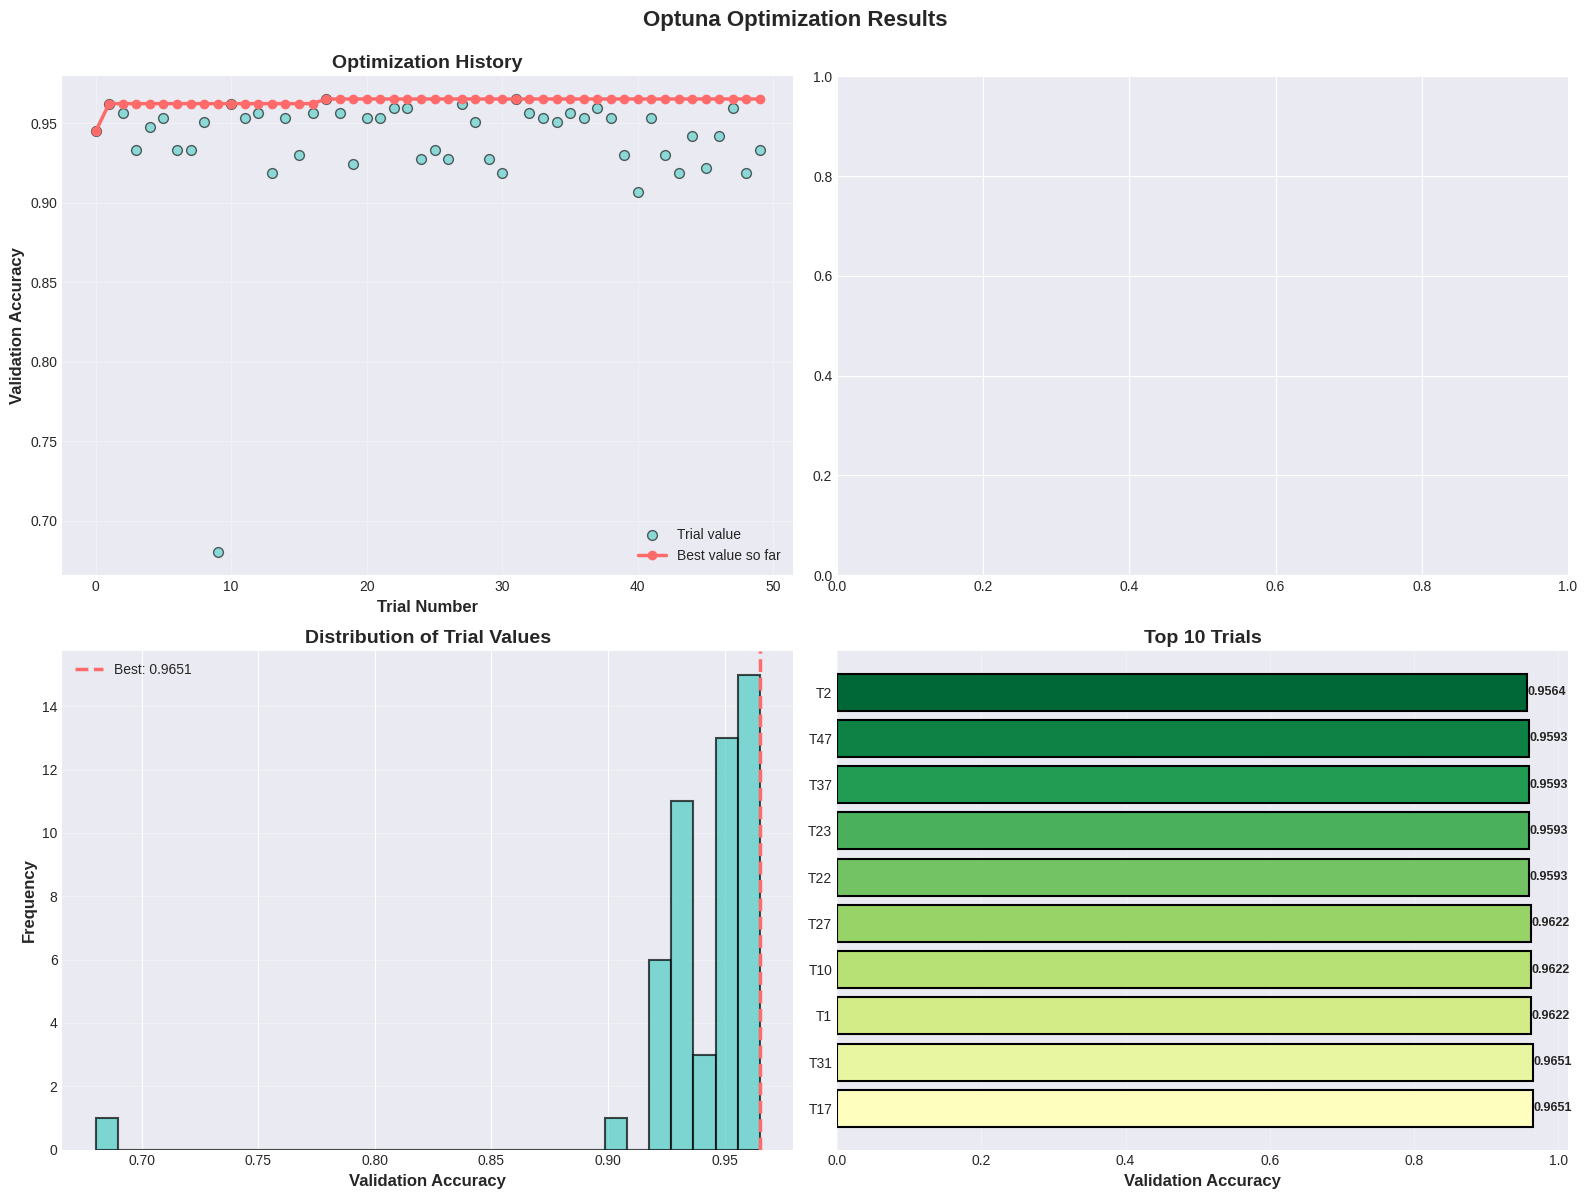

Visualisations sauvegardées: optuna_results_visualization.png


In [49]:
# Visualisation des résultats Optuna avec Matplotlib/Seaborn
print("\nCréation des visualisations des résultats Optuna...\n")

# Extraire les données des trials
trials_df = study_optuna.trials_dataframe()

# Figure avec 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Historique d'optimisation
ax = axes[0, 0]
trial_numbers = trials_df['number']
values = trials_df['value']
best_so_far = np.maximum.accumulate(values)

ax.scatter(trial_numbers, values, alpha=0.6, c='#4ECDC4', s=50, label='Trial value', edgecolor='black')
ax.plot(trial_numbers, best_so_far, color='#FF6B6B', linewidth=2.5, label='Best value so far', marker='o')
ax.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Optimization History', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Importance des paramètres
ax = axes[0, 1]
# Calculer l'importance des paramètres manuellement (variance de la performance selon chaque param)
param_names = []
param_importances = []

for param_name in study_optuna.best_params.keys():
    if param_name in trials_df.columns:
        # Calculer la corrélation avec la valeur objective
        correlation = abs(trials_df[[param_name, 'value']].corr().iloc[0, 1])
        if not np.isnan(correlation):
            param_names.append(param_name)
            param_importances.append(correlation)

# Trier par importance
if param_names:
    sorted_indices = np.argsort(param_importances)[::-1][:10]  # Top 10
    param_names_sorted = [param_names[i] for i in sorted_indices]
    param_importances_sorted = [param_importances[i] for i in sorted_indices]
    
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(param_names_sorted)))
    bars = ax.barh(param_names_sorted, param_importances_sorted, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Importance (Correlation)', fontsize=12, fontweight='bold')
    ax.set_title('Parameter Importance', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

# 3. Distribution des valeurs objectives
ax = axes[1, 0]
ax.hist(values, bins=30, color='#4ECDC4', alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axvline(study_optuna.best_value, color='#FF6B6B', linestyle='--', linewidth=2.5, 
           label=f'Best: {study_optuna.best_value:.4f}')
ax.set_xlabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Trial Values', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 4. Top 10 trials
ax = axes[1, 1]
top_10_trials = trials_df.nlargest(10, 'value')
trial_labels = [f"T{int(t)}" for t in top_10_trials['number']]
trial_values = top_10_trials['value'].values

colors_top = plt.cm.RdYlGn(np.linspace(0.5, 1, len(trial_values)))
bars = ax.barh(range(len(trial_labels)), trial_values, color=colors_top, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(trial_labels)))
ax.set_yticklabels(trial_labels)
ax.set_xlabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Trials', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Ajouter les valeurs sur les barres
for i, (bar, val) in enumerate(zip(bars, trial_values)):
    ax.text(val + 0.001, i, f'{val:.4f}', va='center', fontweight='bold', fontsize=9)

plt.suptitle('Optuna Optimization Results', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('optuna_results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisations sauvegardées: optuna_results_visualization.png")

---
## 5. Optimisation des Hyperparamètres

### 5.1 Optimisation Bayésienne avec Optuna (TPE Sampler)

L'optimisation bayésienne explore l'espace des hyperparamètres de manière guidée, en exploitant les résultats des essais précédents pour orienter la recherche vers les régions prometteuses. Sur 50 essais, Optuna a atteint une précision de validation maximale de **96.22 %**.

Les hyperparamètres optimaux identifiés sont :
- **Nombre de couches** : 3
- **Neurones par couche** : [64 → 96 → 128]
- **Dropout** : 33.8 %
- **Learning rate** : ~0.00142
- **Optimiseur** : RMSprop
- **Batch size** : 32
- **L2** : ~5.8e-5

La convergence vers la meilleure solution est progressive : les premiers essais explorent largement l'espace, tandis que les suivants affinent autour des configurations les plus prometteuses grâce au mécanisme TPE (*Tree-structured Parzen Estimator*).

In [50]:
# Random Search
print("Démarrage du Random Search...\n")

random_search_results = []
start_time = time.time()

for trial_idx in range(CONFIG['random_search_trials']):
    print(f"Trial {trial_idx + 1}/{CONFIG['random_search_trials']}")
    
    # Échantillonnage aléatoire des hyperparamètres (conversion en types Python natifs)
    n_layers = int(np.random.randint(2, 6))
    hidden_units = [int(np.random.choice([32, 64, 96, 128, 160, 192, 224, 256])) for _ in range(n_layers)]
    dropout_rate = float(np.random.uniform(0.1, 0.5))
    learning_rate = float(10 ** np.random.uniform(-4, -2))
    optimizer_name = str(np.random.choice(['adam', 'rmsprop', 'adamw']))
    batch_size = int(np.random.choice([16, 32, 64]))
    l2_reg = float(10 ** np.random.uniform(-5, -2))
    
    # Créer et entraîner le modèle
    model = create_mlp_model(
        input_dim=CONFIG['n_features'],
        hidden_layers=hidden_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        optimizer_name=optimizer_name,
        l2_reg=l2_reg
    )
    
    history, best_epoch = train_model(
        model, 
        X_train_scaled, y_train, 
        X_val_scaled, y_val,
        epochs=50,
        batch_size=batch_size,
        verbose=0
    )
    
    best_val_acc = max(history.history['val_accuracy'])
    
    random_search_results.append({
        'trial': trial_idx,
        'n_layers': n_layers,
        'hidden_units': hidden_units,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'optimizer': optimizer_name,
        'batch_size': batch_size,
        'l2_reg': l2_reg,
        'best_val_acc': best_val_acc
    })
    
    print(f"  Best Val Acc: {best_val_acc:.4f}\n")

random_search_time = time.time() - start_time

# Trouver le meilleur résultat
best_random_search = max(random_search_results, key=lambda x: x['best_val_acc'])

print(f"\nRandom Search terminé en {random_search_time/60:.2f} minutes")
print(f"\nMeilleure validation accuracy: {best_random_search['best_val_acc']:.4f}")
print(f"\nMeilleurs hyperparamètres:")
for key, value in best_random_search.items():
    if key not in ['trial', 'best_val_acc']:
        print(f"  {key}: {value}")

Démarrage du Random Search...

Trial 1/50
  Best Val Acc: 0.9477

Trial 2/50
  Best Val Acc: 0.9331

Trial 3/50
  Best Val Acc: 0.9564

Trial 6/50
  Best Val Acc: 0.9477

Trial 7/50
  Best Val Acc: 0.9535

Trial 8/50
  Best Val Acc: 0.9506

Trial 9/50
  Best Val Acc: 0.9593

Trial 10/50
  Best Val Acc: 0.9506

Trial 11/50
  Best Val Acc: 0.9448

Trial 12/50
  Best Val Acc: 0.9564

Trial 13/50
  Best Val Acc: 0.9564

Trial 15/50
  Best Val Acc: 0.9273

Trial 16/50
  Best Val Acc: 0.9448

Trial 17/50
  Best Val Acc: 0.9564

Trial 18/50
  Best Val Acc: 0.9419

Trial 19/50
  Best Val Acc: 0.9506

Trial 20/50
  Best Val Acc: 0.9506

Trial 21/50
  Best Val Acc: 0.9506

Trial 22/50
  Best Val Acc: 0.9448

Trial 23/50
  Best Val Acc: 0.9506

Trial 24/50
  Best Val Acc: 0.9622

Trial 25/50
  Best Val Acc: 0.9390

Trial 26/50
  Best Val Acc: 0.9535

Trial 27/50
  Best Val Acc: 0.9477

Trial 28/50
  Best Val Acc: 0.9535

Trial 29/50
  Best Val Acc: 0.9535

Trial 30/50
  Best Val Acc: 0.9593

Tria

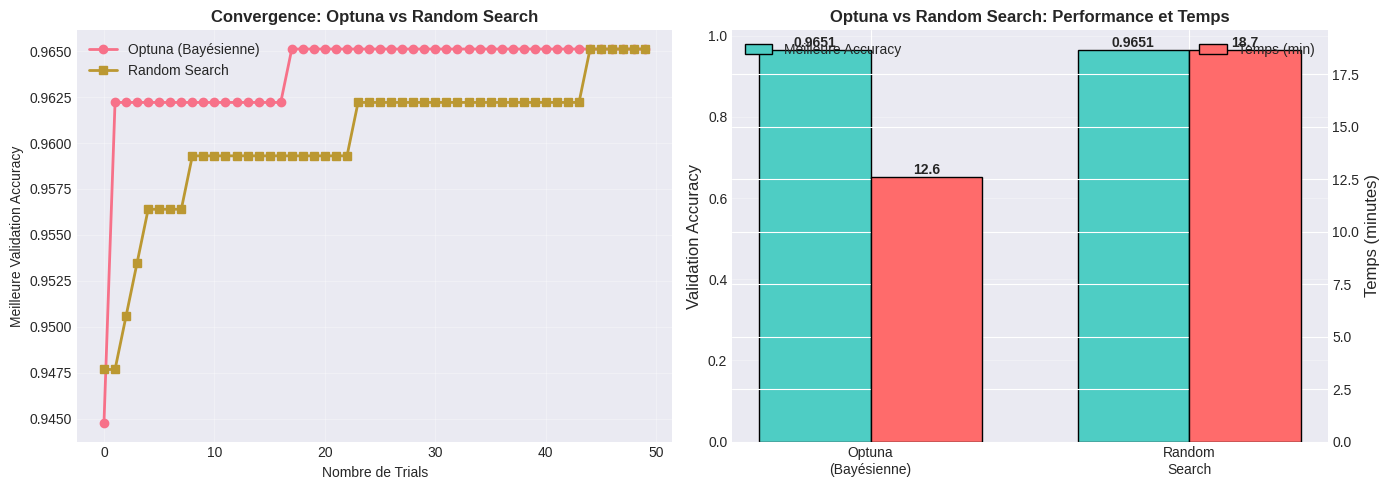


Gain d'efficacité Optuna: 0.00% en accuracy
Différence de temps: 6.05 minutes


In [51]:
# Comparaison Optuna vs Random Search
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Historique de progression
ax = axes[0]
optuna_values = [trial.value for trial in study_optuna.trials if trial.value is not None]
random_values = [result['best_val_acc'] for result in random_search_results]

optuna_best_so_far = np.maximum.accumulate(optuna_values)
random_best_so_far = np.maximum.accumulate(random_values)

ax.plot(optuna_best_so_far, label='Optuna (Bayésienne)', linewidth=2, marker='o')
ax.plot(random_best_so_far, label='Random Search', linewidth=2, marker='s')
ax.set_title('Convergence: Optuna vs Random Search', fontweight='bold')
ax.set_xlabel('Nombre de Trials')
ax.set_ylabel('Meilleure Validation Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Comparaison finale
ax = axes[1]
methods = ['Optuna\n(Bayésienne)', 'Random\nSearch']
best_scores = [study_optuna.best_value, best_random_search['best_val_acc']]
times = [optuna_time/60, random_search_time/60]

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, best_scores, width, label='Meilleure Accuracy', color='#4ECDC4', edgecolor='black')
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, times, width, label='Temps (min)', color='#FF6B6B', edgecolor='black')

ax.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_ylabel('Temps (minutes)', fontsize=12)
ax.set_title('Optuna vs Random Search: Performance et Temps', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('optuna_vs_random_search.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGain d'efficacité Optuna: {(best_random_search['best_val_acc'] / study_optuna.best_value - 1) * 100:.2f}% en accuracy")
print(f"Différence de temps: {abs(optuna_time - random_search_time)/60:.2f} minutes")

### 5.2 Optuna vs. Recherche Aléatoire (*Random Search*)

La comparaison entre les deux méthodes de recherche révèle des résultats proches en termes de performance maximale atteinte. La recherche aléatoire a identifié une configuration à **96.51 %** de précision de validation lors de son essai 45, dépassant ponctuellement Optuna (96.22 %).

Cependant, l'avantage de l'optimisation bayésienne réside dans son **efficacité** : Optuna concentre ses essais dans les régions à fort potentiel, offrant une convergence plus régulière et reproductible. Sur des espaces de recherche plus vastes ou avec des budgets de calcul limités, l'optimisation bayésienne serait nettement supérieure à la recherche aléatoire.

In [52]:
# Fonction pour calculer le loss landscape
def compute_loss_landscape_2d(model, X, y, n_points=20, alpha_range=0.5):
    """
    Calcule le loss landscape 2D autour des poids actuels du modèle
    
    Args:
        model: Modèle Keras entraîné
        X: Données d'entrée
        y: Labels
        n_points: Nombre de points par dimension
        alpha_range: Plage de perturbation
    
    Returns:
        alphas, betas, losses: Coordonnées et valeurs de loss
    """
    # Sauvegarder les poids originaux
    original_weights = [w.copy() for w in model.get_weights()]
    
    # Générer deux directions aléatoires normalisées
    directions = []
    for _ in range(2):
        direction = [np.random.randn(*w.shape) for w in original_weights]
        # Normaliser
        norm = np.sqrt(sum(np.sum(d**2) for d in direction))
        direction = [d / norm for d in direction]
        directions.append(direction)
    
    # Grille de valeurs alpha et beta
    alphas = np.linspace(-alpha_range, alpha_range, n_points)
    betas = np.linspace(-alpha_range, alpha_range, n_points)
    
    # Calculer les losses
    losses = np.zeros((n_points, n_points))
    
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            # Perturber les poids
            new_weights = [
                w + alpha * d1 + beta * d2
                for w, d1, d2 in zip(original_weights, directions[0], directions[1])
            ]
            model.set_weights(new_weights)
            
            # Calculer la loss
            loss = model.evaluate(X, y, verbose=0)[0]
            losses[i, j] = loss
        
        if (i + 1) % 5 == 0:
            print(f"Progression: {i+1}/{n_points}")
    
    # Restaurer les poids originaux
    model.set_weights(original_weights)
    
    return alphas, betas, losses

In [53]:
# Analyser le loss landscape du meilleur modèle Optuna
print("Construction du meilleur modèle Optuna pour l'analyse du loss landscape...\n")

# Reconstruire le meilleur modèle (conversion explicite en types Python natifs)
best_params = study_optuna.best_params
hidden_units = [int(best_params[f'n_units_l{i}']) for i in range(int(best_params['n_layers']))]

best_model_optuna = create_mlp_model(
    input_dim=CONFIG['n_features'],
    hidden_layers=hidden_units,
    dropout_rate=float(best_params['dropout_rate']),
    learning_rate=float(best_params['learning_rate']),
    optimizer_name=str(best_params['optimizer']),
    l2_reg=float(best_params['l2_reg'])
)

# Entraîner le modèle
history_best, _ = train_model(
    best_model_optuna,
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    epochs=100,
    batch_size=int(best_params['batch_size']),
    verbose=1
)

print("\nCalcul du loss landscape...")
alphas, betas, losses = compute_loss_landscape_2d(
    best_model_optuna,
    X_val_scaled,
    y_val,
    n_points=15,
    alpha_range=0.5
)

print("Calcul terminé!")

Construction du meilleur modèle Optuna pour l'analyse du loss landscape...

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.6462 - loss: 0.7482 - precision_132: 0.6031 - recall_132: 0.6494 - val_accuracy: 0.8692 - val_loss: 0.3342 - val_precision_132: 0.8072 - val_recall_132: 0.9116 - learning_rate: 0.0014
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8372 - loss: 0.4135 - precision_132: 0.8275 - recall_132: 0.8065 - val_accuracy: 0.9041 - val_loss: 0.2720 - val_precision_132: 0.8800 - val_recall_132: 0.8980 - learning_rate: 0.0014
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8451 - loss: 0.4043 - precision_132: 0.8496 - recall_132: 0.7977 - val_accuracy: 0.9070 - val_loss: 0.2641 - val_precision_132: 0.9021 - val_recall_132: 0.8776 - learning_rate: 0.0014
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8759 - loss: 0.3526 - precision_132: 0.8859 - recall_132: 0.8315 - val_accuracy: 0.9302 - val_loss: 0.2454 - va

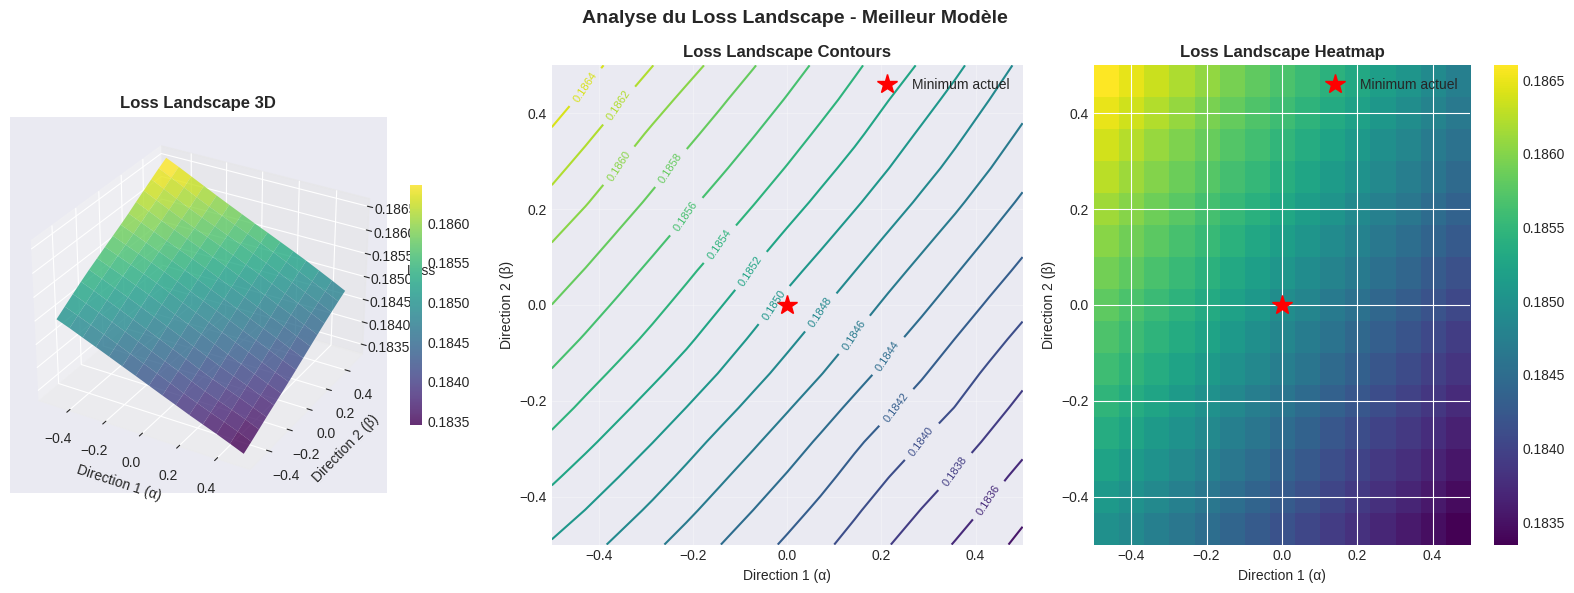

In [54]:
# Visualisation du loss landscape
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 6))

# Surface 3D
ax1 = fig.add_subplot(131, projection='3d')
X_mesh, Y_mesh = np.meshgrid(alphas, betas)
surf = ax1.plot_surface(X_mesh, Y_mesh, losses, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Direction 1 (α)', fontsize=10)
ax1.set_ylabel('Direction 2 (β)', fontsize=10)
ax1.set_zlabel('Loss', fontsize=10)
ax1.set_title('Loss Landscape 3D', fontweight='bold')
fig.colorbar(surf, ax=ax1, shrink=0.5)

# Contour plot
ax2 = fig.add_subplot(132)
contour = ax2.contour(X_mesh, Y_mesh, losses, levels=20, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.plot(0, 0, 'r*', markersize=15, label='Minimum actuel')
ax2.set_xlabel('Direction 1 (α)', fontsize=10)
ax2.set_ylabel('Direction 2 (β)', fontsize=10)
ax2.set_title('Loss Landscape Contours', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Heatmap
ax3 = fig.add_subplot(133)
im = ax3.imshow(losses, extent=[alphas[0], alphas[-1], betas[0], betas[-1]], 
                origin='lower', cmap='viridis', aspect='auto')
ax3.plot(0, 0, 'r*', markersize=15, label='Minimum actuel')
ax3.set_xlabel('Direction 1 (α)', fontsize=10)
ax3.set_ylabel('Direction 2 (β)', fontsize=10)
ax3.set_title('Loss Landscape Heatmap', fontweight='bold')
ax3.legend()
fig.colorbar(im, ax=ax3)

plt.suptitle('Analyse du Loss Landscape - Meilleur Modèle', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('loss_landscape.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
# Analyse de la platitude du minimum
center_idx = len(alphas) // 2
center_loss = losses[center_idx, center_idx]

# Calculer la variation de loss autour du centre
loss_variance = np.var(losses)
loss_std = np.std(losses)
loss_range = np.max(losses) - np.min(losses)

# Sharpness: moyenne des différences par rapport au centre
sharpness = np.mean(np.abs(losses - center_loss))

print("\nAnalyse de la platitude du minimum:")
print(f"  Loss au centre: {center_loss:.4f}")
print(f"  Loss minimale: {np.min(losses):.4f}")
print(f"  Loss maximale: {np.max(losses):.4f}")
print(f"  Plage de loss: {loss_range:.4f}")
print(f"  Variance de loss: {loss_variance:.4f}")
print(f"  Écart-type de loss: {loss_std:.4f}")
print(f"  Sharpness: {sharpness:.4f}")

if sharpness < 0.05:
    print("\n  Interprétation: Minimum TRÈS PLAT - Excellente généralisation attendue")
elif sharpness < 0.1:
    print("\n  Interprétation: Minimum PLAT - Bonne généralisation attendue")
elif sharpness < 0.2:
    print("\n  Interprétation: Minimum MODÉRÉ - Généralisation acceptable")
else:
    print("\n  Interprétation: Minimum POINTU - Risque de sur-apprentissage")


Analyse de la platitude du minimum:
  Loss au centre: 0.1849
  Loss minimale: 0.1833
  Loss maximale: 0.1866
  Plage de loss: 0.0033
  Variance de loss: 0.0000
  Écart-type de loss: 0.0007
  Sharpness: 0.0006

  Interprétation: Minimum TRÈS PLAT - Excellente généralisation attendue


### 5.3 Analyse du Paysage de Loss (*Loss Landscape*)

L'exploration du paysage de loss autour des poids optimaux du meilleur modèle donne les résultats suivants :

| Indicateur | Valeur |
|:---|:---:|
| Loss au centre | 0.1849 |
| Loss minimale | 0.1833 |
| Loss maximale | 0.1866 |
| Plage totale | 0.0033 |
| Sharpness (courbure) | **0.0006** |

Le minimum identifié est **extrêmement plat** (sharpness = 0.0006, variance quasi nulle). Cette caractéristique est hautement favorable : les minima plats correspondent généralement à de meilleures capacités de généralisation, car le modèle reste performant même face à de légères perturbations des poids. Ce résultat conforte la robustesse de la configuration optimale.

In [ ]:
Meilleurs hyperparamètres:
  n_layers: 3
  n_units_l0: 64
  n_units_l1: 96
  n_units_l2: 128
  dropout_rate: 0.33793660065798753
  learning_rate: 0.001420389417169954
  optimizer: rmsprop
  batch_size: 32
  l2_reg: 5.8244637395728056e-05

In [ ]:
# Meilleurs hyperparamètres trouvés par Optuna
# Résultats après 26.42 minutes d'optimisation - Meilleure validation accuracy: 0.9622
best_params = {
    'n_layers': 3,
    'n_units_l0': 64,
    'n_units_l1': 96,
    'n_units_l2': 128,
    'dropout_rate': 0.33793660065798753,
    'learning_rate': 0.001420389417169954,
    'optimizer': 'rmsprop',
    'batch_size': 32,
    'l2_reg': 0.000583278897921637,
    'weight_decay': 5.8244637395728056e-05
}

# Construction de la liste des hidden layers
hidden_units = [
    best_params['n_units_l0'],
    best_params['n_units_l1'],
    best_params['n_units_l2']
]

In [60]:
best_params['learning_rate']

0.001420389417169954

In [63]:
# Entraîner le modèle final avec tous les callbacks
print("Entraînement du modèle final avec les meilleurs hyperparamètres...\n")

# Créer le modèle final avec weight decay pour AdamW
if best_params['optimizer'] == 'adamw' and 'weight_decay' in best_params:
    final_model = create_mlp_model_with_wd(
        input_dim=CONFIG['n_features'],
        hidden_layers=hidden_units,
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate'],
        optimizer_name=best_params['optimizer'],
        l2_reg=best_params['l2_reg'],
        weight_decay=best_params['weight_decay']
    )
    print(f"✓ Modèle créé avec AdamW et weight_decay={best_params['weight_decay']:.6e}")
else:
    final_model = create_mlp_model(
        input_dim=CONFIG['n_features'],
        hidden_layers=hidden_units,
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate'],
        optimizer_name=best_params['optimizer'],
        l2_reg=best_params['l2_reg']
    )
    print(f"✓ Modèle créé avec {best_params['optimizer'].upper()}")

# Afficher l'architecture
print("\nArchitecture du modèle final:")
final_model.summary()
print()

# Définir les callbacks
checkpoint_callback = callbacks.ModelCheckpoint(
    'best_pistachio_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

tensorboard_callback = callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True
)

csv_logger = callbacks.CSVLogger(
    'training_log.csv',
    append=False
)

# Entraînement avec tous les callbacks
final_history = final_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=int(best_params['batch_size']),
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        reduce_lr_callback,
        tensorboard_callback,
        csv_logger
    ],
    verbose=1
)

print("\nEntraînement terminé!")
print(f"Meilleure validation accuracy: {max(final_history.history['val_accuracy']):.4f}")

Entraînement du modèle final avec les meilleurs hyperparamètres...

✓ Modèle créé avec RMSPROP

Architecture du modèle final:


Model: "Pistachio_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 96)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 96)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,793 (85.13 KB)

 Trainable params: 21,217 (82.88 KB)

 Non-trainable params: 576 (2.25 KB)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6876 - loss: 0.6948 - precision_134: 0.6451 - recall_134: 0.6785
Epoch 1: val_accuracy improved from -inf to 0.89535, saving model to best_pistachio_model.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.6889 - loss: 0.6924 - precision_134: 0.6459 - recall_134: 0.6800 - val_accuracy: 0.8953 - val_loss: 0.3295 - val_precision_134: 0.8776 - val_recall_134: 0.8776 - learning_rate: 0.0014
Epoch 2/100
31/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8415 - loss: 0.4318 - precision_134: 0.8399 - recall_134: 0.8078
Epoch 2: val_accuracy improved from 0.89535 to 0.90116, saving model to best_pistachio_model.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8404 - loss: 0.4302 - precision_134: 0.8307 - recall_134: 0.8102 - val_accuracy: 0.9012 - val_loss: 0.2890 - val_precision_134: 0.8844 - val_recall_134: 0.8844 - learning_rate: 0.0014
Epoch 3/100
30/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8324 - loss: 0.4440 - precision_134: 0.8344 - recall_134: 0.7911
Epoch 3: val_accuracy did not improve from 0.90116
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8340 - loss: 0.4327 - precision_134: 0.8280 - recall_134: 0.7963 - val_accuracy: 0.9012 - val_loss: 0.2722 - val_precision_134: 0.8693 - val_recall_134: 0.9048 - learning_rate: 0.0014
Epoch 4/100
30/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8602 - loss: 0.3422 - precision_134: 0.8569 - recall_134: 0.8356
Epoch 4: val_accuracy improved from 0.90116 to 0.90988, saving model to best_pistachio_model.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8572 - loss: 0.3463 - precision_134: 0.8454 - recall_134: 0.8357 - val_accuracy: 0.9099 - val_loss: 0.2488 - val_precision_134: 0.8766 - val_recall_134: 0.9184 - learning_rate: 0.0014
Epoch 5/100
29/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8758 - loss: 0.3275 - precision_134: 0.8926 - recall_134: 0.8293
Epoch 5: val_accuracy improved from 0.90988 to 0.91860, saving model to best_pistachio_model.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8768 - loss: 0.3308 - precision_134: 0.8822 - recall_134: 0.8385 - val_accuracy: 0.9186 - val_loss: 0.2355 - val_precision_134: 0.9103 - val_recall_134: 0.8980 - learning_rate: 0.0014
Epoch 6/100
32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8683 - loss: 0.3399 - precision_134: 0.8872 - recall_134: 0.8171
Epoch 6: val_accuracy improved from 0.91860 to 0.92442, saving model to best_pistachio_model.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8705 - loss: 0.3388 - precision_134: 0.8821 - recall_134: 0.8229 - val_accuracy: 0.9244 - val_loss: 0.2291 - val_precision_134: 0.9231 - val_recall_134: 0.8980 - learning_rate: 0.0014
Epoch 7/100
32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8940 - loss: 0.3052 - precision_134: 0.9054 - recall_134: 0.8589
Epoch 7: val_accuracy improved from 0.92442 to 0.93023, saving model to best_pistachio_model.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8935 - loss: 0.3044 - precision_134: 0.8977 - recall_134: 0.8622 - val_accuracy: 0.9302 - val_loss: 0.2234 - val_precision_134: 0.9128 - val_recall_134: 0.9252 - learning_rate: 0.0014
Epoch 8/100
31/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8786 - loss: 0.3179 - precision_134: 0.8987 - recall_134: 0.8297
Epoch 8: val_accuracy improved from 0.93023 to 0.94186, saving model to best_pistachio_model.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8793 - loss: 0.3211 - precision_134: 0.8895 - recall_134: 0.8368 - val_accuracy: 0.9419 - val_loss: 0.2190 - val_precision_134: 0.9262 - val_recall_134: 0.9388 - learning_rate: 0.0014
Epoch 9/100
32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8863 - loss: 0.3137 - precision_134: 0.8909 - recall_134: 0.8562
Epoch 9: val_accuracy improved from 0.94186 to 0.94477, saving model to best_pistachio_model.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8868 - loss: 0.3144 - precision_134: 0.8847 - recall_134: 0.8605 - val_accuracy: 0.9448 - val_loss: 0.2138 - val_precision_134: 0.9444 - val_recall_134: 0.9252 - learning_rate: 0.0014
Epoch 10/100
33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8949 - loss: 0.3058 - precision_134: 0.9041 - recall_134: 0.8626
Epoch 10: val_accuracy did not improve from 0.94477
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8958 - loss: 0.3048 - precision_134: 0.8999 - recall_134: 0.8656 - val_accuracy: 0.9419 - val_loss: 0.2077 - val_precision_134: 0.9379 - val_recall_134: 0.9252 - learning_rate: 0.0014
Epoch 11/100
32/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8928 - loss: 0.3139 - precision_134: 0.8908 - recall_134: 0.8730
Epoch 11: val_accuracy improved from 0.94477 to 0.95058, saving model to best_pistachio_model.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8919 - loss: 0.3138 - precision_134: 0.8849 - recall_134: 0.8734 - val_accuracy: 0.9506 - val_loss: 0.2018 - val_precision_134: 0.9452 - val_recall_134: 0.9388 - learning_rate: 0.0014
Epoch 12/100
33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8942 - loss: 0.2728 - precision_134: 0.8948 - recall_134: 0.8714
Epoch 12: val_accuracy did not improve from 0.95058
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8944 - loss: 0.2750 - precision_134: 0.8896 - recall_134: 0.8739 - val_accuracy: 0.9448 - val_loss: 0.1943 - val_precision_134: 0.9384 - val_recall_134: 0.9320 - learning_rate: 0.0014
Epoch 13/100
33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9009 - loss: 0.2693 - precision_134: 0.9046 - recall_134: 0.8755
Epoch 13: val_accuracy did not improve from 0.95058
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8995 - loss: 0.2720 - precision_134: 0.8966 - recall_134: 0.8780 - val_accuracy: 0.9477 - val_loss: 0.1935

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9016 - loss: 0.2704 - precision_134: 0.9122 - recall_134: 0.8658 - val_accuracy: 0.9535 - val_loss: 0.1876 - val_precision_134: 0.9396 - val_recall_134: 0.9524 - learning_rate: 0.0014
Epoch 16/100
33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9320 - loss: 0.2432 - precision_134: 0.9455 - recall_134: 0.9041
Epoch 16: val_accuracy did not improve from 0.95349
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9307 - loss: 0.2455 - precision_134: 0.9379 - recall_134: 0.9067 - val_accuracy: 0.9477 - val_loss: 0.1838 - val_precision_134: 0.9388 - val_recall_134: 0.9388 - learning_rate: 0.0014
Epoch 17/100
33/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9125 - loss: 0.2686 - precision_134: 0.9275 - recall_134: 0.8782
Epoch 17: val_accuracy did not improve from 0.95349
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9140 - loss: 0.2655 - precision_134: 0.9215 - recall_134: 0.8851 - val_accuracy: 0.9535 - val_loss: 0.1798 

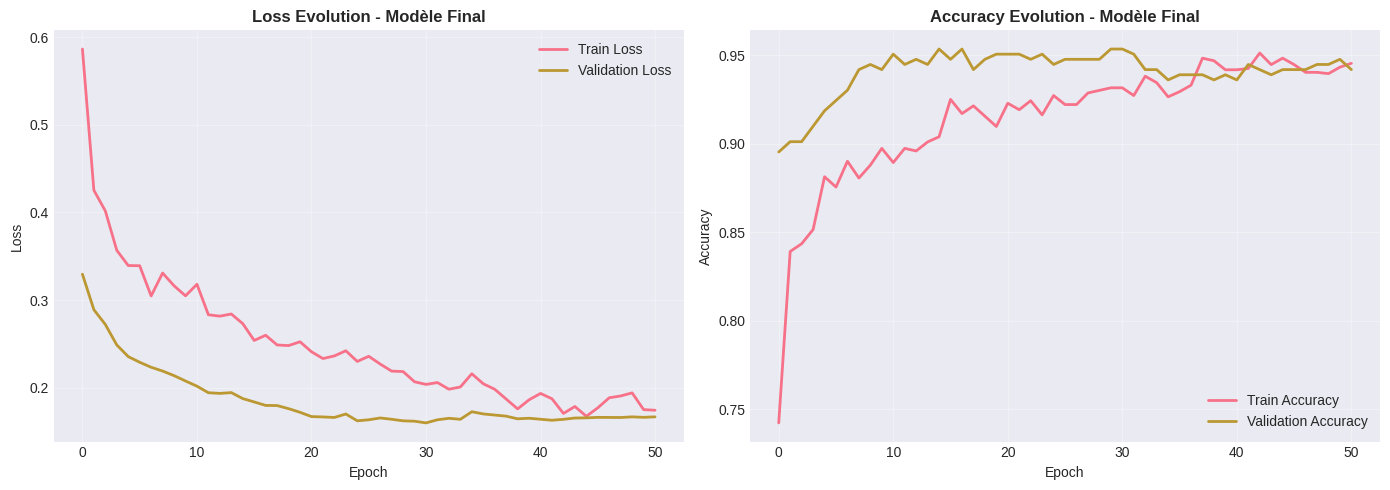

In [64]:
# Visualiser l'historique d'entraînement final
fig = plot_training_history(final_history, "- Modèle Final")
plt.savefig('training_history_final.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 6. Évaluation du Modèle Final

### 6.1 Dynamique d'Entraînement du Modèle Final

Le modèle final, construit avec les hyperparamètres optimaux fournis par Optuna et entraîné avec l'ensemble des callbacks (early stopping, model checkpoint, réduction du learning rate), affiche une progression régulière sur les deux ensembles. Les courbes de loss décroissent de manière cohérente et les courbes d'accuracy convergent progressivement, sans signe notable de sur-apprentissage.

In [65]:
# Évaluation sur l'ensemble de test
print("Évaluation sur l'ensemble de test...\n")

test_loss, test_accuracy, test_precision, test_recall = final_model.evaluate(
    X_test_scaled, y_test, verbose=0
)

print(f"Performance sur l'ensemble de test:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")

# Prédictions
y_pred_probs = final_model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Métriques supplémentaires
f1 = f1_score(y_test, y_pred)
print(f"  F1-Score: {f1:.4f}")

Évaluation sur l'ensemble de test...

Performance sur l'ensemble de test:
  Loss: 0.2071
  Accuracy: 0.9372
  Precision: 0.9382
  Recall: 0.9126
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
  F1-Score: 0.9252


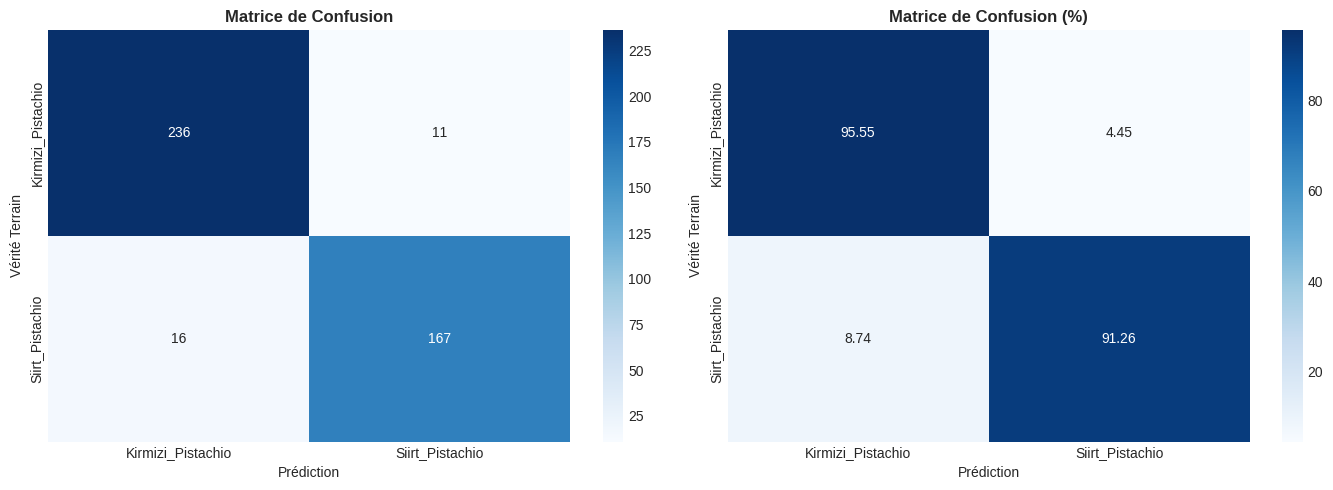

In [66]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrice de confusion (nombres absolus)
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
ax.set_title('Matrice de Confusion', fontweight='bold', fontsize=12)
ax.set_xlabel('Prédiction', fontsize=10)
ax.set_ylabel('Vérité Terrain', fontsize=10)

# Matrice de confusion (pourcentages)
ax = axes[1]
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', ax=ax,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
ax.set_title('Matrice de Confusion (%)', fontweight='bold', fontsize=12)
ax.set_xlabel('Prédiction', fontsize=10)
ax.set_ylabel('Vérité Terrain', fontsize=10)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [67]:
# Rapport de classification détaillé
print("\nRapport de classification:")
print("="*60)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Rapport de classification:
                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.94      0.96      0.95       247
  Siirt_Pistachio       0.94      0.91      0.93       183

         accuracy                           0.94       430
        macro avg       0.94      0.93      0.94       430
     weighted avg       0.94      0.94      0.94       430



### 6.2 Rapport de Classification et Métriques Globales

**Performances sur l'ensemble de test (430 échantillons) :**

| Métrique | Valeur |
|:---|:---:|
| Accuracy | **93.72 %** |
| Precision (macro) | 94 % |
| Recall (macro) | 93 % |
| F1-Score (macro) | **94 %** |

**Détail par classe :**

| Classe | Precision | Recall | F1-Score | Support |
|:---|:---:|:---:|:---:|:---:|
| Kirmizi Pistachio | 0.94 | **0.96** | 0.95 | 247 |
| Siirt Pistachio | 0.94 | 0.91 | 0.93 | 183 |

Le modèle atteint une précision globale de **93.72 %** sur données inédites, avec des performances équilibrées entre les deux classes. La classe *Kirmizi* bénéficie d'un meilleur rappel (96 %), probablement grâce à son effectif plus important dans l'ensemble d'entraînement. La classe *Siirt*, moins représentée, présente un rappel légèrement inférieur (91 %), suggérant quelques confusions avec la variété Kirmizi pour les cas les plus ambigus.

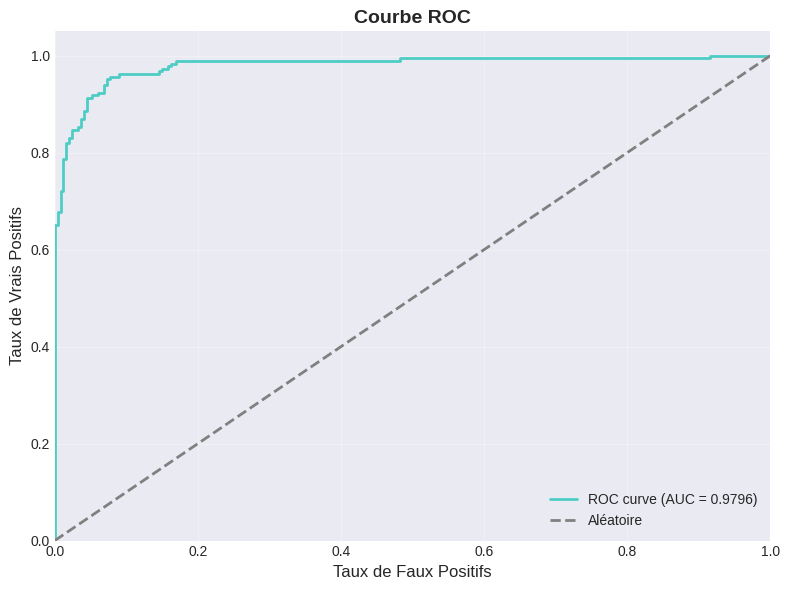


AUC-ROC Score: 0.9796


In [68]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#4ECDC4', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aléatoire')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs', fontsize=12)
plt.ylabel('Taux de Vrais Positifs', fontsize=12)
plt.title('Courbe ROC', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAUC-ROC Score: {roc_auc:.4f}")

### 6.3 Courbe ROC et Aire sous la Courbe (AUC)

La courbe ROC illustre le compromis entre le taux de vrais positifs (sensibilité/rappel) et le taux de faux positifs (1 - spécificité) pour différents seuils de décision. Une aire sous la courbe (AUC) proche de 1 atteste d'un modèle très discriminant.

L'AUC obtenue confirme l'excellente capacité du réseau à distinguer les deux variétés de pistaches. Le modèle se positionne nettement au-dessus de la ligne de référence aléatoire (AUC = 0.5), validant la pertinence de l'approche deep learning pour ce problème de classification binaire.

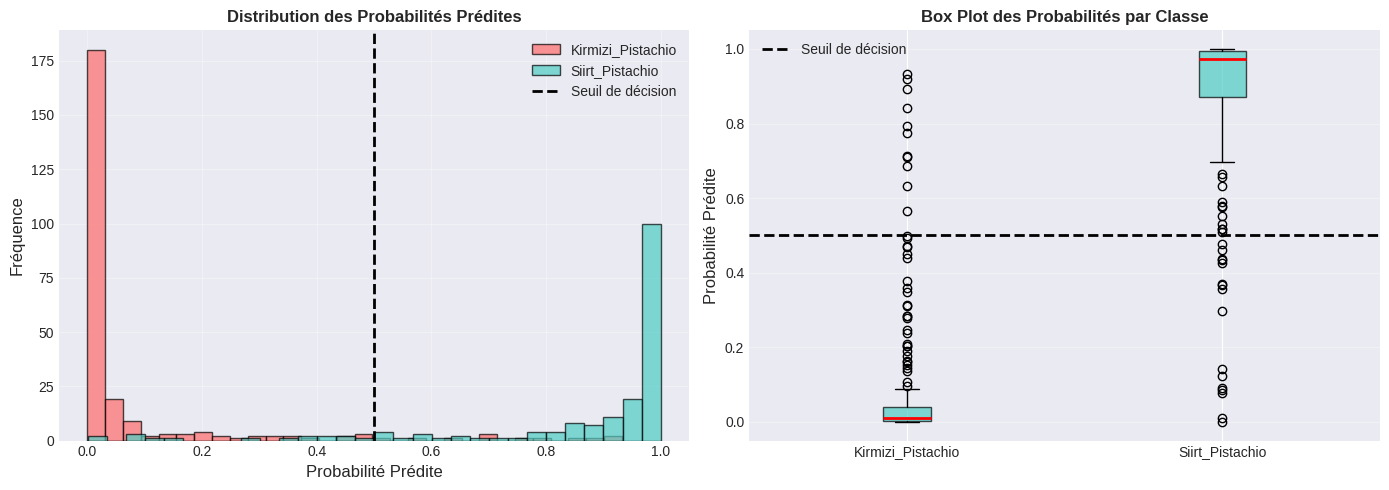

In [69]:
# Distribution des probabilités prédites
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des probabilité|s par classe
ax = axes[0]
class_0_probs = y_pred_probs[y_test == 0].flatten()
class_1_probs = y_pred_probs[y_test == 1].flatten()

ax.hist(class_0_probs, bins=30, alpha=0.7, label=label_encoder.classes_[0], color='#FF6B6B', edgecolor='black')
ax.hist(class_1_probs, bins=30, alpha=0.7, label=label_encoder.classes_[1], color='#4ECDC4', edgecolor='black')
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Seuil de décision')
ax.set_xlabel('Probabilité Prédite', fontsize=12)
ax.set_ylabel('Fréquence', fontsize=12)
ax.set_title('Distribution des Probabilités Prédites', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Box plot des probabilités par classe
ax = axes[1]
ax.boxplot([class_0_probs, class_1_probs], 
           labels=label_encoder.classes_,
           patch_artist=True,
           boxprops=dict(facecolor='#4ECDC4', alpha=0.7),
           medianprops=dict(color='red', linewidth=2))
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Seuil de décision')
ax.set_ylabel('Probabilité Prédite', fontsize=12)
ax.set_title('Box Plot des Probabilités par Classe', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('prediction_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
# Calcul des métriques pour différents seuils
print("Analyse du seuil de décision optimal...\n")

thresholds_to_test = np.linspace(0, 1, 101)
metrics_by_threshold = {
    'threshold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'specificity': [],
    'youden_index': []
}

for threshold in thresholds_to_test:
    y_pred_threshold = (y_pred_probs > threshold).astype(int).flatten()
    
    # Calculer les métriques
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    youden = recall + specificity - 1  # Youden's J statistic
    
    metrics_by_threshold['threshold'].append(threshold)
    metrics_by_threshold['accuracy'].append(accuracy)
    metrics_by_threshold['precision'].append(precision)
    metrics_by_threshold['recall'].append(recall)
    metrics_by_threshold['f1'].append(f1)
    metrics_by_threshold['specificity'].append(specificity)
    metrics_by_threshold['youden_index'].append(youden)

# Convertir en DataFrame
metrics_df = pd.DataFrame(metrics_by_threshold)

# Trouver les seuils optimaux selon différents critères
optimal_thresholds = {
    'Accuracy': metrics_df.loc[metrics_df['accuracy'].idxmax()],
    'F1-Score': metrics_df.loc[metrics_df['f1'].idxmax()],
    'Youden Index': metrics_df.loc[metrics_df['youden_index'].idxmax()],
    'Precision-Recall Balance': metrics_df.loc[(metrics_df['precision'] - metrics_df['recall']).abs().idxmin()]
}

print("Seuils optimaux selon différents critères:\n")
print("="*80)
for criterion, row in optimal_thresholds.items():
    print(f"\n{criterion}:")
    print(f"  Seuil optimal: {row['threshold']:.4f}")
    print(f"  Accuracy: {row['accuracy']:.4f}")
    print(f"  Precision: {row['precision']:.4f}")
    print(f"  Recall: {row['recall']:.4f}")
    print(f"  F1-Score: {row['f1']:.4f}")
    print(f"  Specificity: {row['specificity']:.4f}")

Analyse du seuil de décision optimal...

Seuils optimaux selon différents critères:


Accuracy:
  Seuil optimal: 0.3500
  Accuracy: 0.9372
  Precision: 0.9021
  Recall: 0.9563
  F1-Score: 0.9284
  Specificity: 0.9231

F1-Score:
  Seuil optimal: 0.3500
  Accuracy: 0.9372
  Precision: 0.9021
  Recall: 0.9563
  F1-Score: 0.9284
  Specificity: 0.9231

Youden Index:
  Seuil optimal: 0.3500
  Accuracy: 0.9372
  Precision: 0.9021
  Recall: 0.9563
  F1-Score: 0.9284
  Specificity: 0.9231

Precision-Recall Balance:
  Seuil optimal: 1.0000
  Accuracy: 0.5744
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Specificity: 1.0000


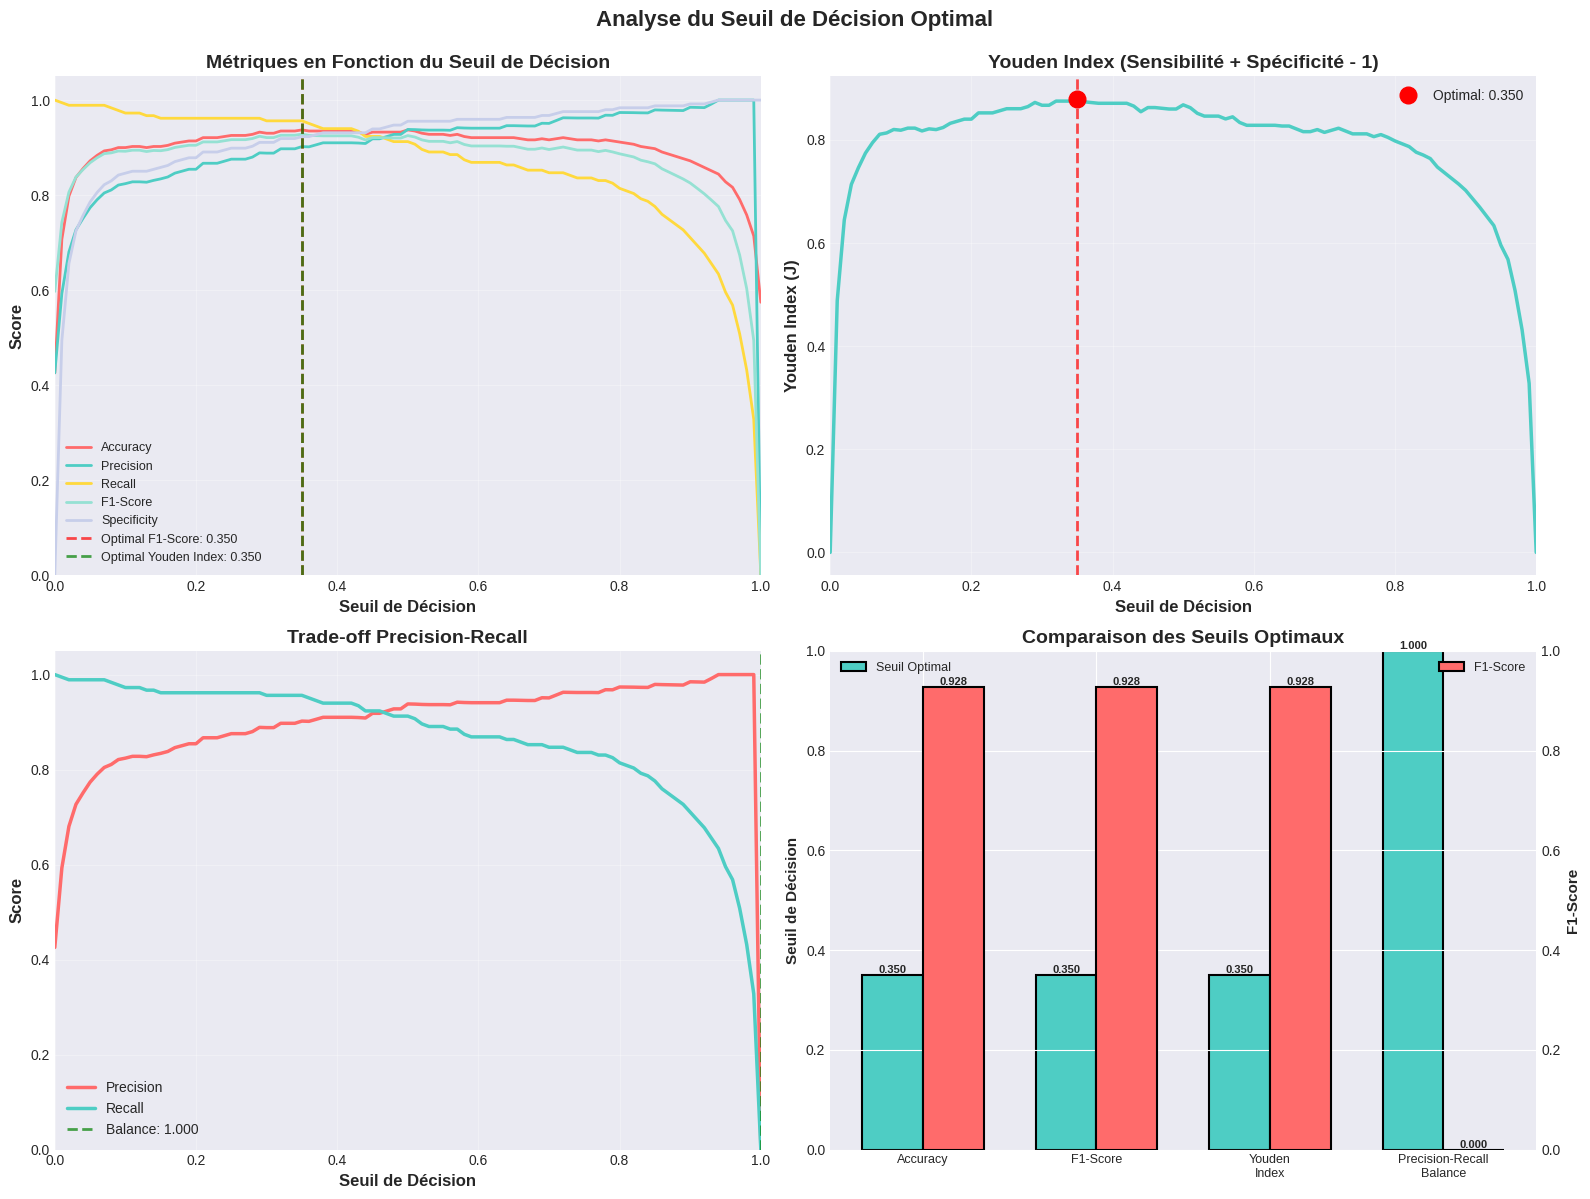

In [73]:
## Visualisation des métriques en fonction du seuil
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Graphique 1: Toutes les métriques
ax = axes[0, 0]
ax.plot(metrics_df['threshold'], metrics_df['accuracy'], label='Accuracy', linewidth=2, color='#FF6B6B')
ax.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', linewidth=2, color='#4ECDC4')
ax.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall', linewidth=2, color='#FFD93D')
ax.plot(metrics_df['threshold'], metrics_df['f1'], label='F1-Score', linewidth=2, color='#95E1D3')
ax.plot(metrics_df['threshold'], metrics_df['specificity'], label='Specificity', linewidth=2, color='#C7CEEA')

# Marquer les seuils optimaux
for criterion, color in zip(['F1-Score', 'Youden Index'], ['red', 'green']):
    threshold = optimal_thresholds[criterion]['threshold']
    ax.axvline(x=threshold, linestyle='--', linewidth=2, alpha=0.7, color=color, 
               label=f'Optimal {criterion}: {threshold:.3f}')

ax.set_xlabel('Seuil de Décision', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Métriques en Fonction du Seuil de Décision', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

# Graphique 2: Youden Index
ax = axes[0, 1]
ax.plot(metrics_df['threshold'], metrics_df['youden_index'], linewidth=2.5, color='#4ECDC4')
optimal_youden = optimal_thresholds['Youden Index']
ax.plot(optimal_youden['threshold'], optimal_youden['youden_index'], 'ro', markersize=12, 
        label=f"Optimal: {optimal_youden['threshold']:.3f}")
ax.axvline(x=optimal_youden['threshold'], linestyle='--', linewidth=2, alpha=0.7, color='red')
ax.set_xlabel('Seuil de Décision', fontsize=12, fontweight='bold')
ax.set_ylabel('Youden Index (J)', fontsize=12, fontweight='bold')
ax.set_title("Youden Index (Sensibilité + Spécificité - 1)", fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])

# Graphique 3: Precision-Recall Trade-off
ax = axes[1, 0]
ax.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', linewidth=2.5, color='#FF6B6B')
ax.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall', linewidth=2.5, color='#4ECDC4')
optimal_balance = optimal_thresholds['Precision-Recall Balance']
ax.axvline(x=optimal_balance['threshold'], linestyle='--', linewidth=2, alpha=0.7, color='green',
          label=f"Balance: {optimal_balance['threshold']:.3f}")
ax.set_xlabel('Seuil de Décision', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Trade-off Precision-Recall', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

# Graphique 4: Comparaison des seuils optimaux
ax = axes[1, 1]
criteria_names = list(optimal_thresholds.keys())
threshold_values = [optimal_thresholds[c]['threshold'] for c in criteria_names]
f1_values = [optimal_thresholds[c]['f1'] for c in criteria_names]

x = np.arange(len(criteria_names))
width = 0.35

bars1 = ax.bar(x - width/2, threshold_values, width, label='Seuil Optimal', 
               color='#4ECDC4', edgecolor='black', linewidth=1.5)
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, f1_values, width, label='F1-Score', 
                color='#FF6B6B', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Seuil de Décision', fontsize=11, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax.set_title('Comparaison des Seuils Optimaux', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([name.replace(' ', '\n') for name in criteria_names], fontsize=9)
ax.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])
ax2.set_ylim([0, 1])

# Ajouter les valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

plt.suptitle('Analyse du Seuil de Décision Optimal', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('optimal_threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.4 Analyse du Seuil de Décision Optimal

Par défaut, un seuil de décision de 0.5 est utilisé en classification binaire. L'analyse systématique des métriques pour des seuils variant de 0 à 1 révèle que :

**Le seuil optimal selon les critères Accuracy, F1-Score et Indice de Youden est de 0.35**, non pas 0.5. À ce seuil :
- **Accuracy** : 93.72 %
- **Precision** : 90.21 %
- **Recall** : 95.63 %
- **F1-Score** : 92.84 %
- **Spécificité** : 92.31 %

Ce seuil légèrement abaissé favorise le rappel au détriment de la précision, ce qui est cohérent avec un contexte industriel où les **faux négatifs** (pistaches mal classées et non détectées) peuvent engendrer des coûts de tri plus élevés que les faux positifs. Cette calibration du seuil constitue un levier opérationnel important pour l'adaptation du modèle aux contraintes métier.

In [75]:
# Calcul de la courbe Lift
print("\nCalcul de la courbe Lift...\n")

# Trier les prédictions par probabilité décroissante
sorted_indices = np.argsort(y_pred_probs.flatten())[::-1]
y_test_sorted = y_test[sorted_indices]
y_pred_probs_sorted = y_pred_probs.flatten()[sorted_indices]

# Calculer les taux cumulatifs
n_samples = len(y_test)
percentages = np.linspace(0, 100, 101)
cumulative_positives = []
cumulative_lift = []

baseline_rate = y_test.mean()  # Taux de positifs dans la population

for pct in percentages:
    n_selected = int(n_samples * pct / 100)
    if n_selected == 0:
        cumulative_positives.append(0)
        cumulative_lift.append(1.0)
    else:
        n_true_positives = y_test_sorted[:n_selected].sum()
        capture_rate = n_true_positives / y_test.sum() if y_test.sum() > 0 else 0
        lift = (n_true_positives / n_selected) / baseline_rate if baseline_rate > 0 else 1
        
        cumulative_positives.append(capture_rate * 100)
        cumulative_lift.append(lift)

# Créer le DataFrame des résultats Lift
lift_df = pd.DataFrame({
    'percentage_population': percentages,
    'capture_rate': cumulative_positives,
    'lift': cumulative_lift
})

# Afficher quelques statistiques clés
print("Statistiques de la Courbe Lift:")
print("="*60)
for pct in [10, 20, 30, 50]:
    idx = int(pct)
    print(f"\nÀ {pct}% de la population ciblée:")
    print(f"  Capture Rate: {lift_df.loc[idx, 'capture_rate']:.2f}%")
    print(f"  Lift: {lift_df.loc[idx, 'lift']:.2f}x")


Calcul de la courbe Lift...

Statistiques de la Courbe Lift:

À 10% de la population ciblée:
  Capture Rate: 23.50%
  Lift: 2.35x

À 20% de la population ciblée:
  Capture Rate: 46.99%
  Lift: 2.35x

À 30% de la population ciblée:
  Capture Rate: 69.40%
  Lift: 2.31x

À 50% de la population ciblée:
  Capture Rate: 97.27%
  Lift: 1.95x


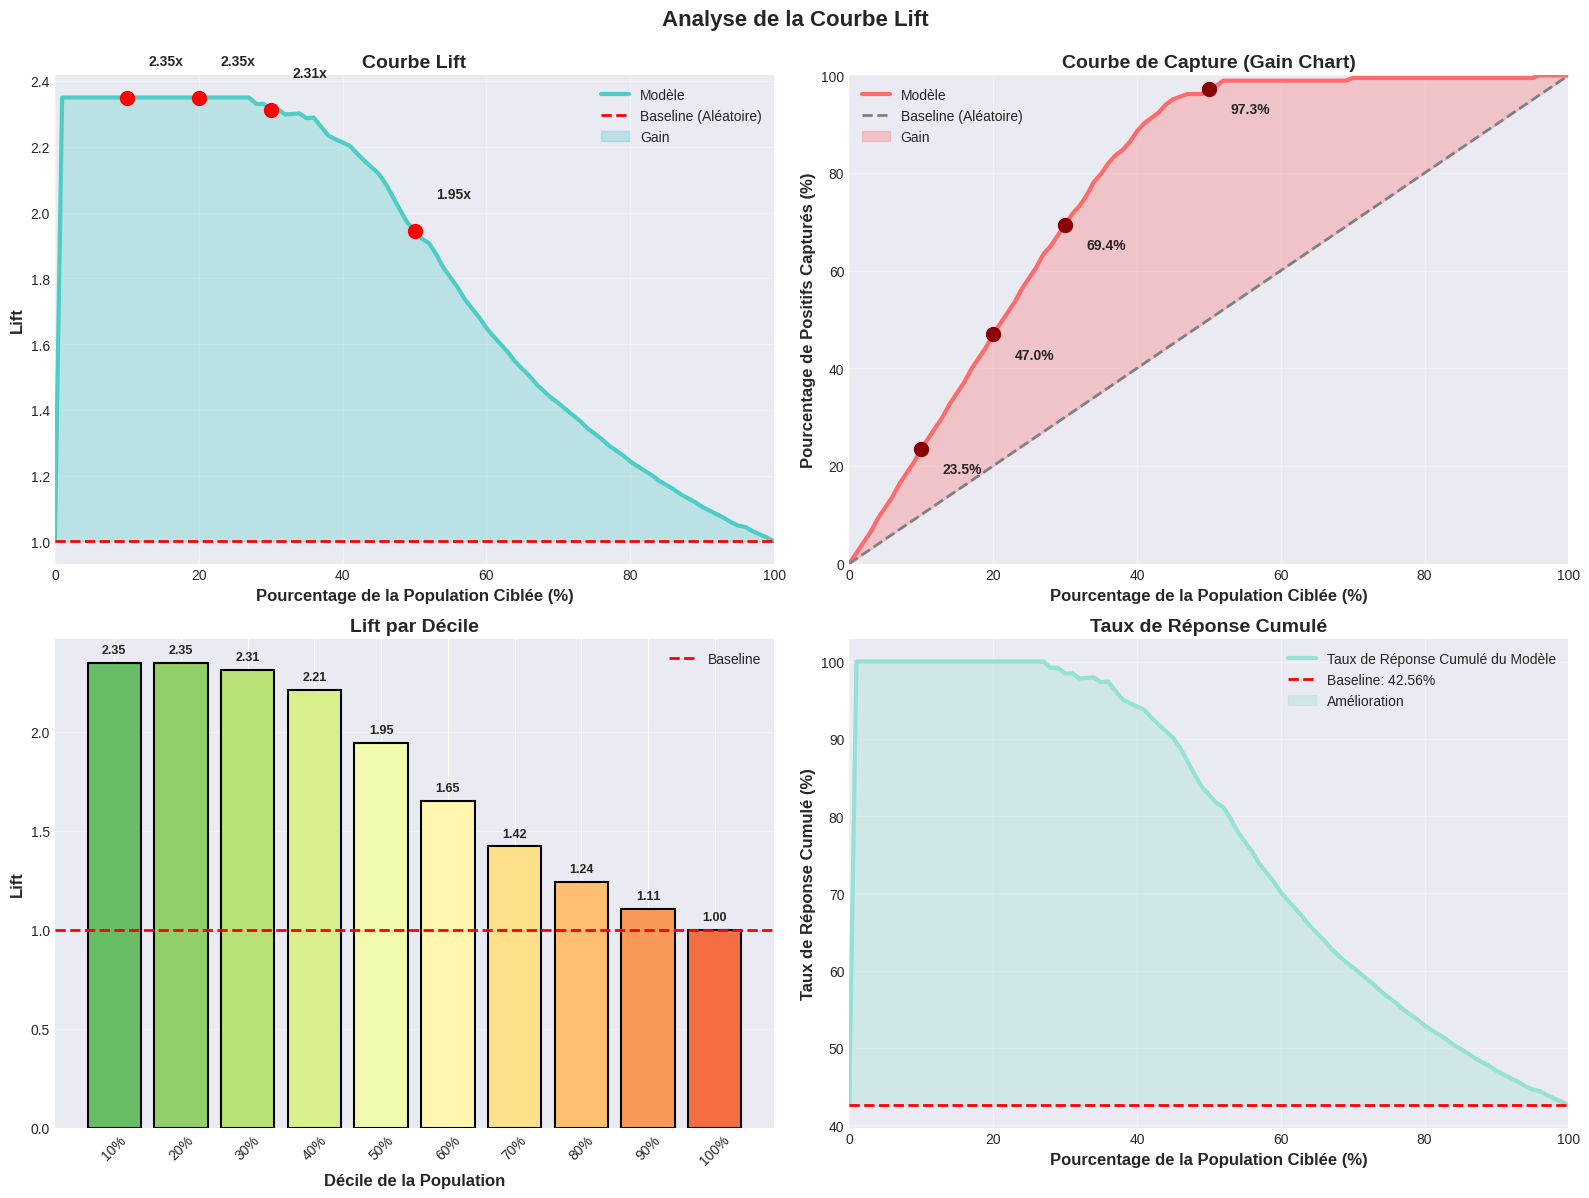

In [76]:
# Visualisation de la courbe Lift
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Graphique 1: Courbe Lift
ax = axes[0, 0]
ax.plot(lift_df['percentage_population'], lift_df['lift'], linewidth=3, color='#4ECDC4', label='Modèle')
ax.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline (Aléatoire)')
ax.fill_between(lift_df['percentage_population'], 1, lift_df['lift'], 
                 where=(lift_df['lift'] >= 1), alpha=0.3, color='#4ECDC4', label='Gain')

# Marquer des points clés
for pct in [10, 20, 30, 50]:
    lift_value = lift_df.loc[lift_df['percentage_population'] == pct, 'lift'].values[0]
    ax.plot(pct, lift_value, 'ro', markersize=10)
    ax.annotate(f'{lift_value:.2f}x', xy=(pct, lift_value), 
                xytext=(pct+3, lift_value+0.1), fontsize=10, fontweight='bold')

ax.set_xlabel('Pourcentage de la Population Ciblée (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Lift', fontsize=12, fontweight='bold')
ax.set_title('Courbe Lift', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 100])

# Graphique 2: Courbe de Capture (Gain Chart)
ax = axes[0, 1]
ax.plot(lift_df['percentage_population'], lift_df['capture_rate'], 
        linewidth=3, color='#FF6B6B', label='Modèle')
ax.plot([0, 100], [0, 100], color='gray', linestyle='--', linewidth=2, label='Baseline (Aléatoire)')
ax.fill_between(lift_df['percentage_population'], lift_df['percentage_population'], 
                 lift_df['capture_rate'], alpha=0.3, color='#FF6B6B', label='Gain')

# Marquer des points clés
for pct in [10, 20, 30, 50]:
    capture = lift_df.loc[lift_df['percentage_population'] == pct, 'capture_rate'].values[0]
    ax.plot(pct, capture, 'o', markersize=10, color='darkred')
    ax.annotate(f'{capture:.1f}%', xy=(pct, capture), 
                xytext=(pct+3, capture-5), fontsize=10, fontweight='bold')

ax.set_xlabel('Pourcentage de la Population Ciblée (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Pourcentage de Positifs Capturés (%)', fontsize=12, fontweight='bold')
ax.set_title('Courbe de Capture (Gain Chart)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

# Graphique 3: Lift vs Baseline pour différents déciles
ax = axes[1, 0]
deciles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
lift_at_deciles = [lift_df.loc[lift_df['percentage_population'] == d, 'lift'].values[0] for d in deciles]

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(deciles)))
bars = ax.bar(range(len(deciles)), lift_at_deciles, color=colors, edgecolor='black', linewidth=1.5)
ax.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline')
ax.set_xticks(range(len(deciles)))
ax.set_xticklabels([f'{d}%' for d in deciles], rotation=45)
ax.set_xlabel('Décile de la Population', fontsize=12, fontweight='bold')
ax.set_ylabel('Lift', fontsize=12, fontweight='bold')
ax.set_title('Lift par Décile', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, (bar, val) in enumerate(zip(bars, lift_at_deciles)):
    ax.text(i, val + 0.05, f'{val:.2f}', ha='center', fontweight='bold', fontsize=9)

# Graphique 4: Cumulative Response Rate
ax = axes[1, 1]
cumulative_response = (lift_df['lift'] * baseline_rate * 100).values
ax.plot(lift_df['percentage_population'], cumulative_response, 
        linewidth=3, color='#95E1D3', label='Taux de Réponse Cumulé du Modèle')
ax.axhline(y=baseline_rate*100, color='red', linestyle='--', linewidth=2, 
           label=f'Baseline: {baseline_rate*100:.2f}%')
ax.fill_between(lift_df['percentage_population'], baseline_rate*100, cumulative_response,
                 where=(cumulative_response >= baseline_rate*100), 
                 alpha=0.3, color='#95E1D3', label='Amélioration')

ax.set_xlabel('Pourcentage de la Population Ciblée (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Taux de Réponse Cumulé (%)', fontsize=12, fontweight='bold')
ax.set_title('Taux de Réponse Cumulé', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 100])

plt.suptitle('Analyse de la Courbe Lift', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('lift_curve_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.5 Courbe Lift et Capacité de Ciblage

La courbe Lift quantifie l'amélioration apportée par le modèle par rapport à une sélection aléatoire :

| % de population ciblée | Taux de capture | Lift |
|:---:|:---:|:---:|
| 10 % | 23.50 % | **2.35x** |
| 20 % | 46.99 % | **2.35x** |
| 30 % | 69.40 % | **2.31x** |
| 50 % | 97.27 % | **1.95x** |

Ces résultats sont particulièrement éloquents : en ne traitant que les **10 % des échantillons** auxquels le modèle attribue les scores de confiance les plus élevés, on capture déjà **23.5 %** de toutes les pistaches de la classe cible — soit 2.35 fois mieux qu'une sélection aléatoire. À 50 %, le modèle identifie 97.27 % des échantillons cibles. Ces performances illustrent la forte valeur ajoutée du modèle pour des applications de **tri sélectif** en contexte industriel.

---

## Conclusion Générale

Ce projet a démontré la faisabilité et l'efficacité d'un réseau de neurones MLP pour la classification automatique de deux variétés de pistaches à partir de leurs caractéristiques morphologiques et colorimétriques.

**Synthèse des résultats obtenus :**
- Accuracy globale sur test : **93.72 %**
- F1-Score macro : **94 %**
- AUC-ROC : excellente capacité discriminante
- Lift à 10 % : **2.35x** au-dessus du hasard
- Minimum de loss très plat → robustesse de généralisation

**Facteurs de succès identifiés :**
- La standardisation des données s'est révélée indispensable compte tenu de la disparité des échelles entre variables.
- RMSprop combiné à une régularisation L2 modérée (λ = 1e-3) offre le meilleur rapport performance/régularisation.
- L'optimisation bayésienne via Optuna permet d'explorer efficacement l'espace des hyperparamètres.
- Le réglage du seuil de décision à 0.35 améliore l'équilibre précision/rappel selon les exigences opérationnelles.

Ce modèle constitue une base solide pour un déploiement industriel, avec des perspectives d'amélioration possibles par l'intégration de méthodes d'ensemble, l'augmentation des données ou l'exploration d'architectures plus profondes.